In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import torch
np.set_printoptions(suppress=True)

In [2]:
from importlib import reload
import protein_transformer
from protein_transformer.losses import mse_over_angles, mse_over_angles_numpy, inverse_trig_transform
from protein_transformer.losses import angles_to_coords

In [3]:
data = torch.load("../../data/proteinnet/casp12_191101_100.pt")

In [27]:
def add_noise(angs, stdev, truncate=True, keep_zeros=False):
    noise = np.random.normal(0, stdev, angs.shape)
    new_ang = ANGLE_MEANS + noise
    if truncate:
        new_ang[new_ang > 1] = 1
        new_ang[new_ang < -1] = -1
    if keep_zeros:
        new_ang[angs == 0] = 0
    return new_ang

def rmse(a, b):
    return np.sqrt(((a-b)**2).mean())

In [35]:
a = np.zeros((100,24))

In [40]:
add_noise(a, 0.5)

array([[ 0.22524498, -0.77728352,  0.49405545, ...,  0.48481988,
         0.78871287, -0.33540149],
       [-0.04502337, -1.        , -0.60171699, ..., -0.23026791,
         1.        ,  0.20871398],
       [-0.11579495, -0.84120843,  0.53996364, ...,  0.5823259 ,
         1.        , -0.27637016],
       ...,
       [ 0.46692884, -0.73012717,  0.46911336, ...,  0.50320765,
         1.        ,  0.02562052],
       [-0.13310028, -0.84899115,  0.76272908, ...,  0.39611182,
         1.        ,  0.29851939],
       [ 0.83427693, -1.        ,  0.79582097, ...,  0.89111549,
         1.        , -0.51043787]])

In [41]:
rmse(add_noise(a, 0.5), a)

0.6159368036839283

In [13]:
ANGLE_MEANS = np.load("../../protein_transformer/protein/casp12_190927_100_angle_means.npy")

In [26]:
ANGLE_MEANS

array([ 0.07595811, -0.7574677 ,  0.14556683,  0.00828046, -0.98326576,
        0.01236546, -0.36099732,  0.93137196, -0.4471832 ,  0.89339287,
       -0.52371272,  0.85047618, -0.73439391,  0.36605564, -0.08406644,
       -0.37392988, -0.13446233, -0.00997297, -0.11665946, -0.13996403,
       -0.46478538, -0.00656155,  0.83980648, -0.00001698])

In [25]:
np.tile(ANGLE_MEANS, 10).reshape(10, 24)

array([[ 0.07595811, -0.7574677 ,  0.14556683,  0.00828046, -0.98326576,
         0.01236546, -0.36099732,  0.93137196, -0.4471832 ,  0.89339287,
        -0.52371272,  0.85047618, -0.73439391,  0.36605564, -0.08406644,
        -0.37392988, -0.13446233, -0.00997297, -0.11665946, -0.13996403,
        -0.46478538, -0.00656155,  0.83980648, -0.00001698],
       [ 0.07595811, -0.7574677 ,  0.14556683,  0.00828046, -0.98326576,
         0.01236546, -0.36099732,  0.93137196, -0.4471832 ,  0.89339287,
        -0.52371272,  0.85047618, -0.73439391,  0.36605564, -0.08406644,
        -0.37392988, -0.13446233, -0.00997297, -0.11665946, -0.13996403,
        -0.46478538, -0.00656155,  0.83980648, -0.00001698],
       [ 0.07595811, -0.7574677 ,  0.14556683,  0.00828046, -0.98326576,
         0.01236546, -0.36099732,  0.93137196, -0.4471832 ,  0.89339287,
        -0.52371272,  0.85047618, -0.73439391,  0.36605564, -0.08406644,
        -0.37392988, -0.13446233, -0.00997297, -0.11665946, -0.13996403,
  

In [ ]:
a = data["train"]["ang"][0][:]
a[np.isnan(a)] = 0
np.random.seed(0)
a_noise = add_noise(a, 1, truncate=False)
np.random.seed(0)
a_noise_truncate = add_noise(a, 1, truncate=True)
print(rmse(a, a_noise))
print(rmse(a, a_noise_truncate))

a_torch, a_noise_truncate_torch = torch.tensor(a), torch.tensor(a_noise_truncate)
print(torch.sqrt(mse_over_angles(a_torch.unsqueeze(dim=0), a_noise_truncate_torch.unsqueeze(dim=0))).item())
print(np.sqrt(mse_over_angles_numpy(np.expand_dims(a, 0), np.expand_dims(a_noise_truncate, 0))))

In [5]:
from protein_transformer.protein.structure_utils import get_backbone_from_full_coords

In [42]:
def angles_have_missing_res(angles):
    return np.isnan(angles).all(axis=-1).any()

In [43]:
def get_coordinates_from_numpy_data(seq, ang_sincos):
    # Add batch dimension
    ang_sincos = ang_sincos[np.newaxis, :]
    
    # Compute angles in radians from sin/cos representaion
    ang_rad = inverse_trig_transform(torch.tensor(ang_sincos, dtype=torch.float))[0]
    
    # Remove nans
    ang_rad[torch.isnan(ang_rad)] = 0
    
    if torch.isnan(ang_rad).any():
        print("Nan in ang_rad.")
        
    seq_as_ints = protein_transformer.dataset.VOCAB.aa_seq2indices(seq, add_sos_eos=False)
    seq_as_ints = torch.tensor(seq_as_ints, dtype=torch.long)
    
    coords = angles_to_coords(ang_rad, seq_as_ints, remove_batch_padding=False)
    return coords
    
    

In [49]:
i = 11
for seq, ang, crd in zip(data["train"]["seq"][i:], data["train"]["ang"][i:], data["train"]["crd"][i:]):
    print(seq)
    print(ang)
    print(crd)
    break

TGRPEWIWLALGTALMGLGTLYFLVKGMGVSDPDAKPFYAITTLVPAIAFTMYLSMLLGYGLTMVPFGGEQNPIYWARYADWLFTTPLLLLDLALLVDADQGTILALVGADGIMIGTGLVGALTKVYSYRFVWWAISTAAMLYILYVLFFGFTSKAESMRPEVASTFKVLRNVTVVLWSAYPVVWLIGSEGAGIVPLNIETLLFMVLDVSAKVGFGLILLRSRAIFG
[[        nan         nan  0.95092025 ...         nan         nan
          nan]
 [ 0.55080746  0.83463234  0.85758262 ...         nan         nan
          nan]
 [ 0.54672625 -0.83731141 -0.77509018 ... -0.85431134  0.99999702
   0.0024416 ]
 ...
 [ 0.0557567  -0.99844439  0.99982571 ...         nan         nan
          nan]
 [-0.15643064 -0.98768895  0.3760204  ...         nan         nan
          nan]
 [ 0.99868198 -0.05132552         nan ...         nan         nan
          nan]]
[[23.775 71.397 13.279]
 [24.255 72.119 12.067]
 [23.344 71.81  10.88 ]
 ...
 [   nan    nan    nan]
 [   nan    nan    nan]
 [   nan    nan    nan]]


In [47]:
np.random.uniform(-1, 1, (100, 24))

array([[ 0.03687448, -0.44902911,  0.21792347, ..., -0.54987698,
        -0.70845778,  0.31383524],
       [ 0.10703496, -0.58629104,  0.69567714, ...,  0.72953028,
         0.49527725,  0.50354138],
       [ 0.81486338, -0.63493798, -0.22183134, ...,  0.03551824,
         0.10859318, -0.29618658],
       ...,
       [-0.58044205,  0.02428945,  0.9163171 , ..., -0.17650817,
         0.02129881, -0.0803852 ],
       [ 0.33266214,  0.41685595, -0.40260076, ..., -0.10265255,
        -0.03178845,  0.88976709],
       [ 0.88413655, -0.11048487, -0.28340585, ..., -0.92801899,
        -0.22503078,  0.85242002]])

In [50]:
def add_noise_and_get_rmse_drmsd(seq, ang, crd, stdev):
    
#     noisy_ang = add_noise(ang, stdev, truncate=True, keep_zeros=False)
    noisy_ang = np.random.uniform(-1, 1, ang.shape)
#     print(noisy_ang -ang)
    
    coords = get_coordinates_from_numpy_data(seq, ang)
    noisy_coords = get_coordinates_from_numpy_data(seq, noisy_ang)
    
    coords = get_backbone_from_full_coords(coords)
    noisy_coords = get_backbone_from_full_coords(noisy_coords)
    
    rmse_val = np.sqrt(mse_over_angles_numpy(noisy_ang[np.newaxis, :], ang[np.newaxis, :]))
    drmsd_val = protein_transformer.losses.drmsd(coords, noisy_coords)
    rmsd_val = protein_transformer.losses.rmsd(coords.numpy(), noisy_coords.numpy())
    
    crd[np.isnan(crd)] = 0
    true_coords = get_backbone_from_full_coords(crd)
    reconstruction_drmsd = protein_transformer.losses.drmsd(coords, torch.tensor(true_coords))
    reconstruction_rmsd = protein_transformer.losses.rmsd(coords.numpy(), true_coords) 
    
    return rmse_val, rmsd_val, drmsd_val, reconstruction_drmsd, reconstruction_rmsd
    
    

In [ ]:
rm, rd, d, d_recon, rd_recon = add_noise_and_get_rmse_drmsd(seq, ang, crd, 1)
print(f"RMSE:\t\t{rm:.4f},\nRMSD:\t\t{rd:.4f},\nRMSD-recon:\t{rd_recon:.4f},\nDRMSD:\t\t{d:.2f},\nDRMSD-rec:\t{d_recon:.2f}")

In [51]:
import tqdm

In [52]:
def study_noise(stdev):
    pbar = tqdm.tqdm(zip(data["train"]["seq"], data["train"]["ang"], data["train"]["crd"]), total=len(data["train"]["seq"]))
    stats = {"RMSE": [], "RMSD": [], "RMSD-recon": [], "DRMSD" : [], "DRMSD-recon": [], "lengths" : []}
    for seq, ang, crd in pbar:
        rmse_total, rmsd_total, drmsd_total, drmsd_recon_total, rmsd_recon_total = 0, 0, 0, 0, 0
        for i in range(10):
            rm, rd, d, d_recon, rd_recon = add_noise_and_get_rmse_drmsd(seq, ang, crd, stdev)
            rmse_total += rm
            rmsd_total += rd
            drmsd_total += d.item()
            drmsd_recon_total += d_recon.item()
            rmsd_recon_total += rd_recon
            
        stats["RMSE"].append(rmse_total/10)
        stats["RMSD"].append(rmsd_total/10)
        stats["RMSD-recon"].append(rmsd_recon_total/10)
        stats["DRMSD-recon"].append(drmsd_recon_total/10)
        stats["DRMSD"].append(drmsd_total/10)
        stats["lengths"].append(ang.shape[0])
        
    return stats
        

In [ ]:
study_noise(1)

In [53]:
def work(seq_ang_crd_stdev):
    seq, ang, crd, stdev = seq_ang_crd_stdev
    if angles_have_missing_res(ang):
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    rmse_total, rmsd_total, drmsd_total, drmsd_recon_total, rmsd_recon_total = 0, 0, 0, 0, 0
    n = 3
    for i in range(3):
        rm, rd, d, d_recon, rd_recon = add_noise_and_get_rmse_drmsd(seq, ang, crd, stdev)
        rmse_total += rm
        rmsd_total += rd
        drmsd_total += d.item()
        drmsd_recon_total += d_recon.item()
        rmsd_recon_total += rd_recon
    return rmse_total/n, rmsd_total/n, rmsd_recon_total/n, drmsd_total/n, drmsd_recon_total/n, ang.shape[0], stdev
    

In [56]:
work((seq, ang, crd, 1))

(0.9170738210726719,
 17.229007529877258,
 0.44794509131694515,
 13.5418119430542,
 0.5419914394377633,
 227,
 1)

In [54]:
from multiprocessing import Pool
p = Pool(2)


In [55]:
import seaborn as sns

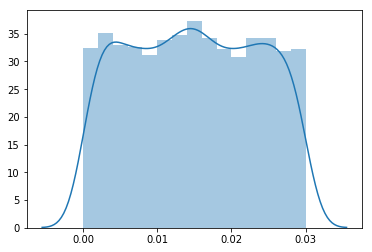

In [20]:
sns.distplot(np.random.uniform(0, 0.03, size=3000))

In [15]:
data["train"]["ang"][4].shape, angles_have_missing_res(data["train"]["ang"][4])

((224, 24), False)

In [ ]:
results1 = list(tqdm.tqdm(p.imap(work, 
                                 zip(data["train"]["seq"][4:5]*3000, 
                                     data["train"]["ang"][4:5]*3000, 
                                     data["train"]["crd"][4:5]*3000, 
                                     np.random.uniform(0, 0.03, size=3000))
                               ), total=3000))

 44%|████▎     | 1307/3000 [14:46<17:21,  1.63it/s]

In [ ]:
lim = 3000
results = list(tqdm.tqdm(p.imap(work, 
                                 zip(data["train"]["seq"][:lim], 
                                     data["train"]["ang"][:lim], 
                                     data["train"]["crd"][:lim], 
                                     np.random.exponential(.5, size=len(data["train"]["seq"][:lim])))
                               ), total=len(data["train"]["seq"][:lim])))

In [ ]:
results = p.map(work, 
                  zip(data["train"]["seq"][:200], 
                      data["train"]["ang"][:200], 
                      data["train"]["crd"][:200], 
                      np.random.exponential(.5, size=200)))

In [19]:
len(results1)

1000

In [23]:
import pandas as pd

In [24]:
sns.set()
sns.set(rc={'figure.facecolor':'white'})

In [25]:
df = pd.DataFrame(results1, columns=["rmse", "rmsd", "rmsd-recon", "drmsd", "drmsd-recon","len", "stdev"])

In [26]:
df["ln-drmsd"] = df["drmsd"] / df["len"]
df["ln-rmsd"] = df["rmsd"] / df["len"]

In [27]:
fig = plt.figure(figsize=(8,4), dpi=300)
sns.distplot(df_nona["len"])
plt.title("Protein Length Distribution")

NameError: name 'df_nona' is not defined

<Figure size 2400x1200 with 0 Axes>

No handles with labels found to put in legend.


Text(0.5,1,'RMSE vs RMSD')

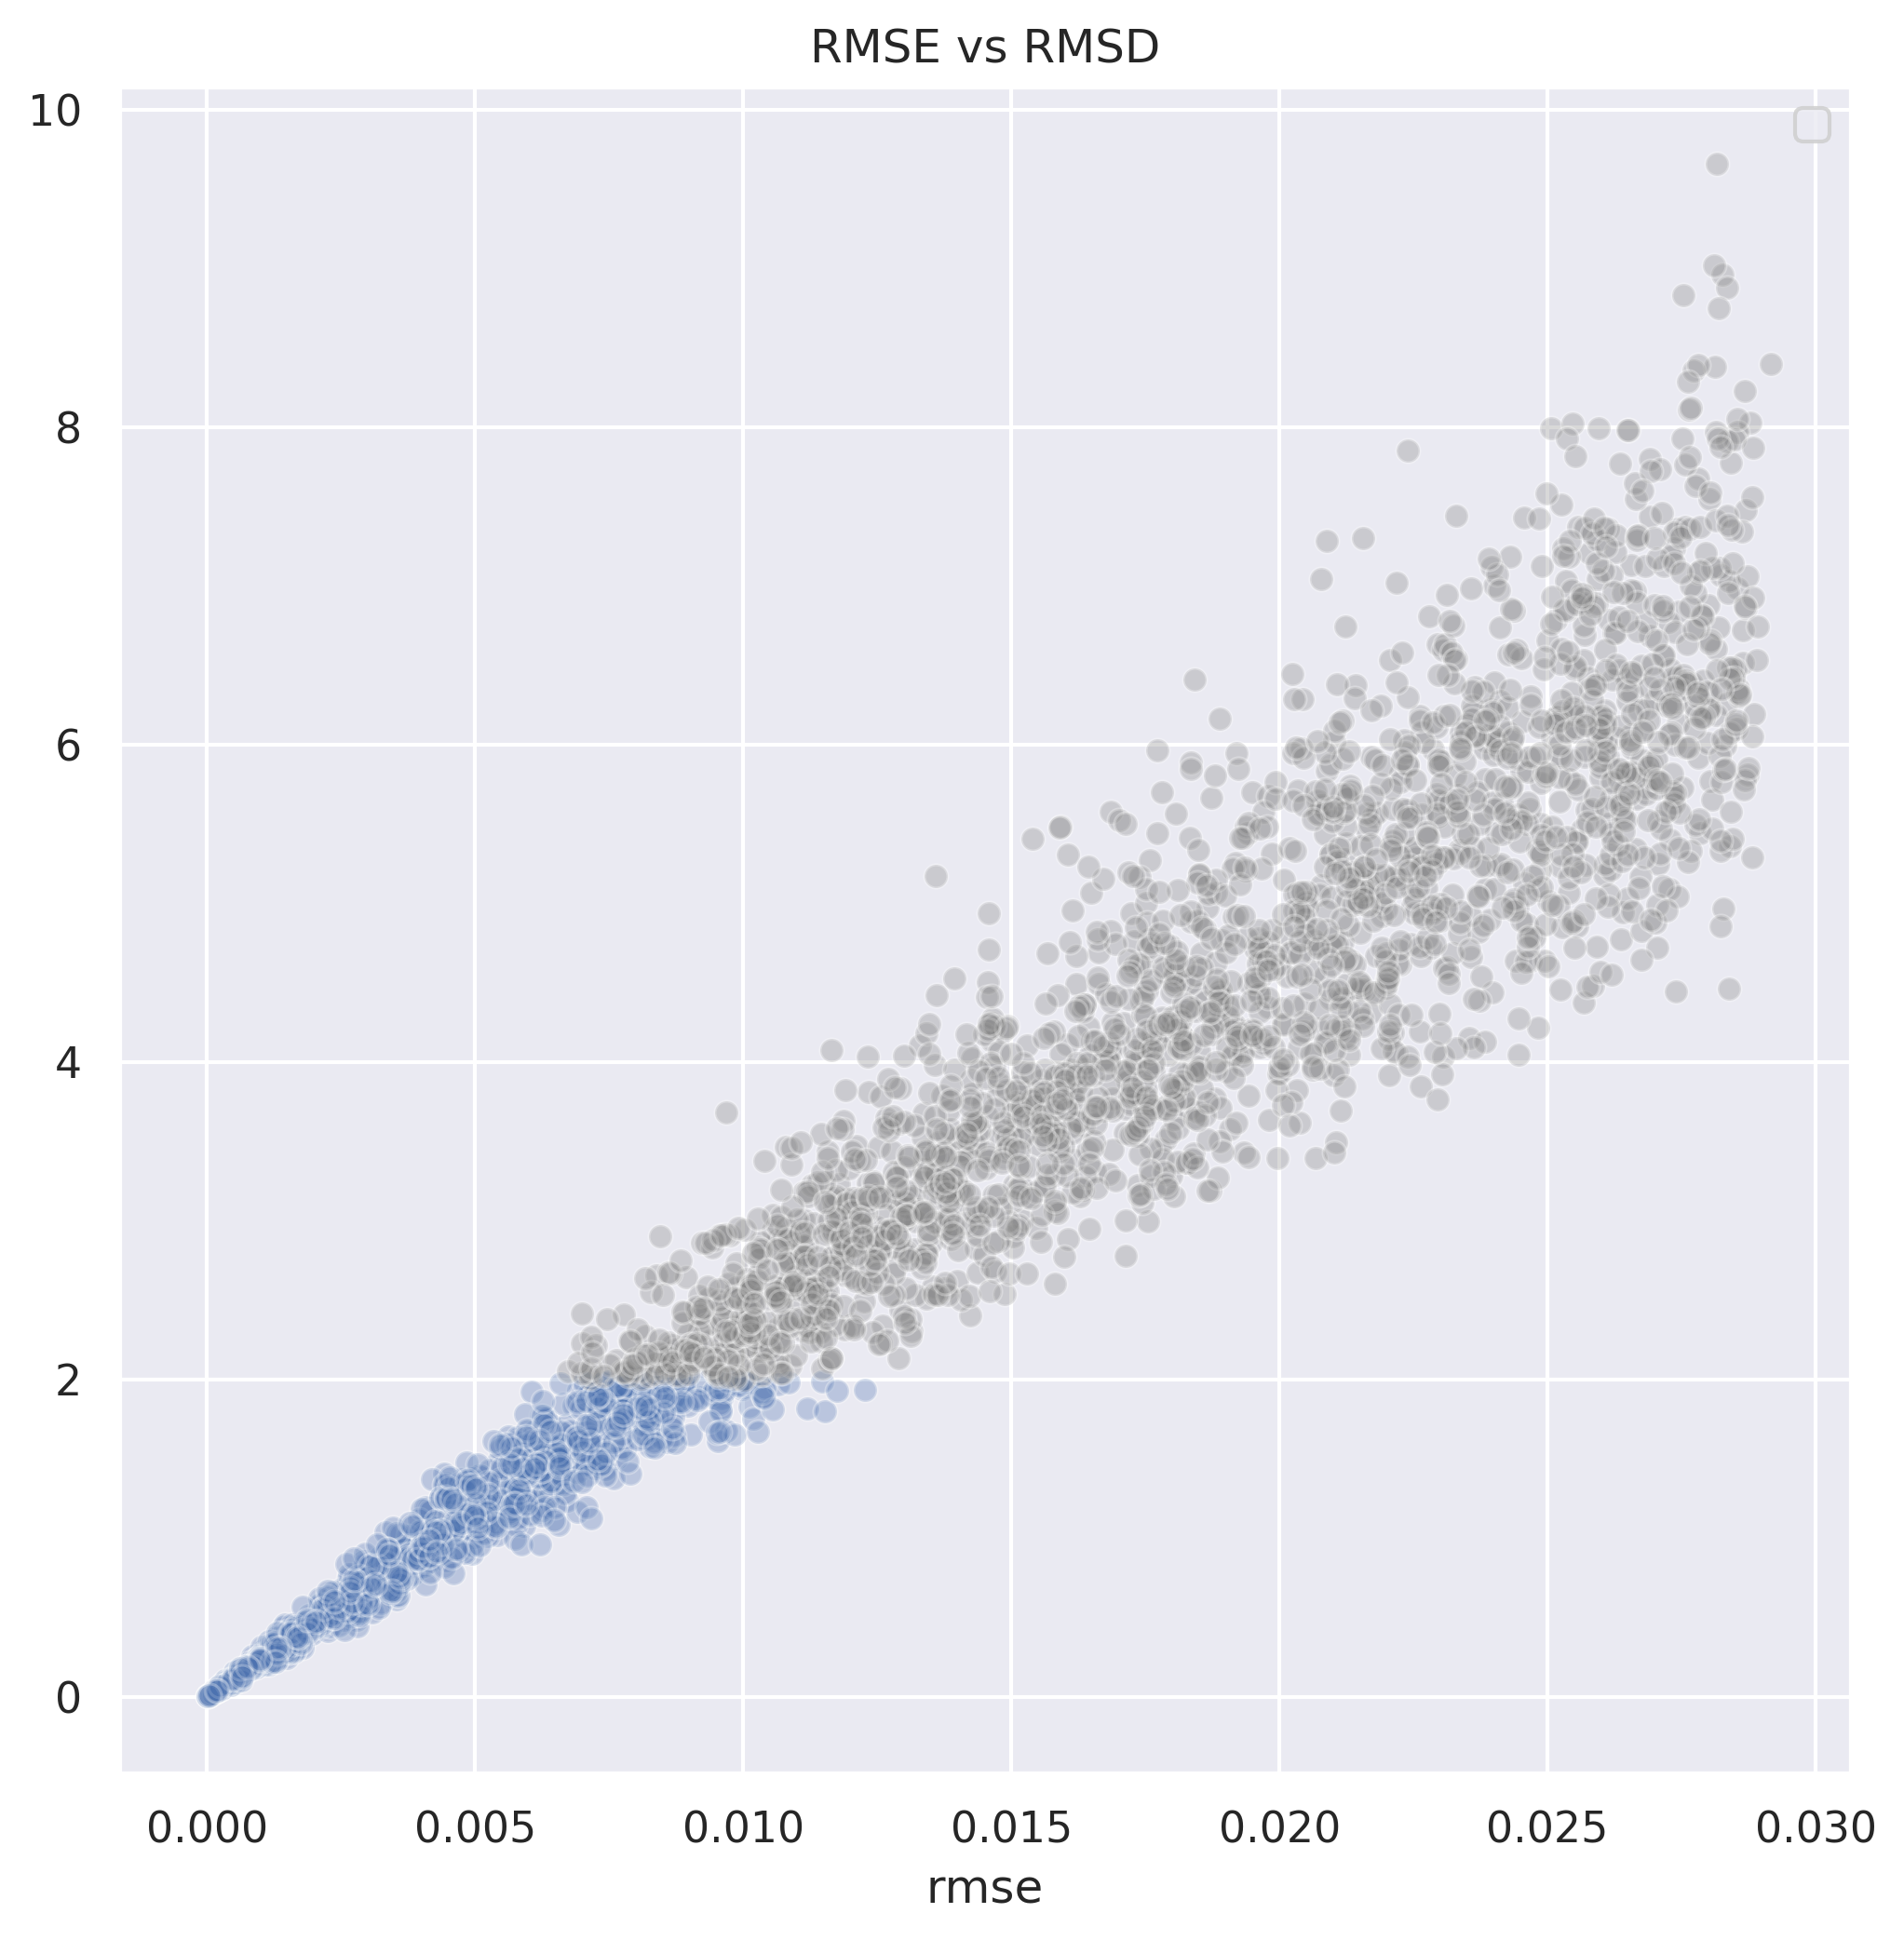

In [34]:
fig = plt.figure(figsize=(8,8), dpi=300)
ax1 = fig.add_subplot(111)
sub1 = df[df["rmsd"] <= 2]
sub2 = df[df["rmsd"] > 2]
sns.scatterplot(sub1["rmse"], sub1["rmsd"], alpha=0.3, ax=ax1)
sns.scatterplot(sub2["rmse"], sub2["rmsd"], alpha=0.3, ax=ax1, color="grey")
# sns.scatterplot(df["rmse"], df["rmsd"], alpha=0.3, ax=ax1, label="rmsd")
# sns.scatterplot(df["rmse"], df["drmsd"], alpha=0.3, ax=ax1, label="drmsd")
plt.ylabel("")
plt.legend()
plt.title("RMSE vs RMSD")

Text(0.5,1,'RMSE vs {LN-RMSD, LN-DRMSD}')

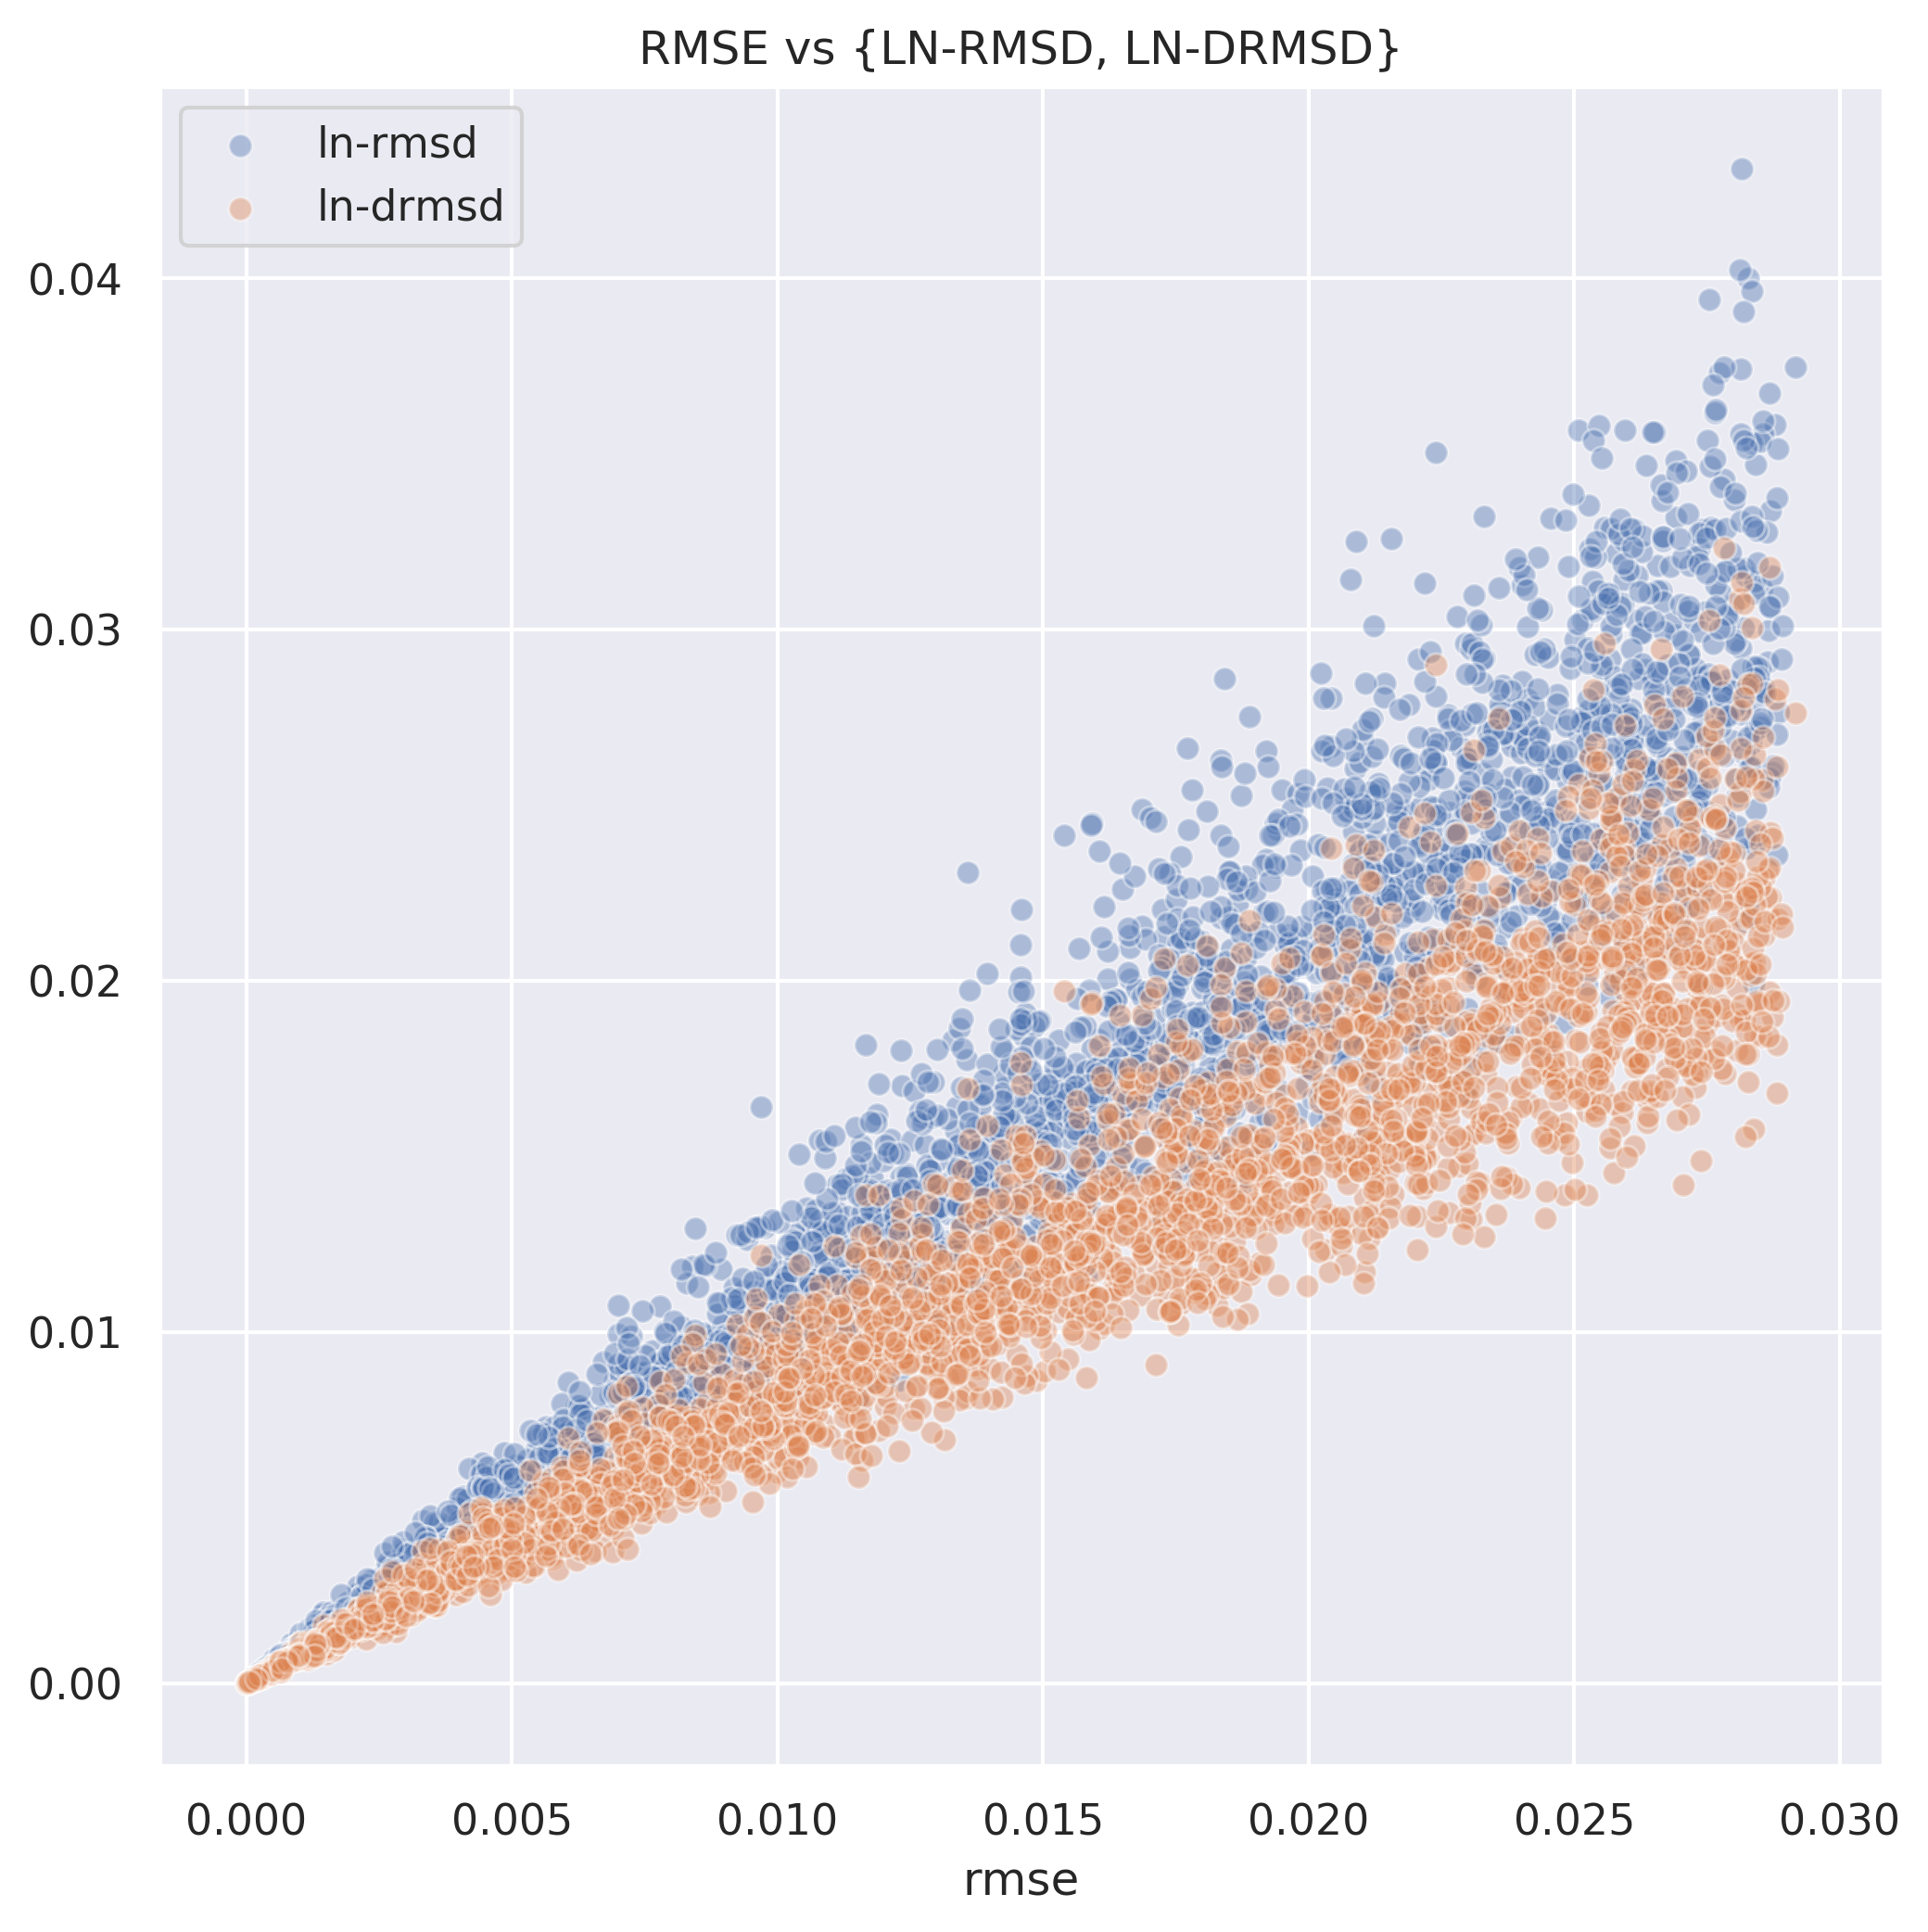

In [29]:
fig = plt.figure(figsize=(8,8), dpi=300)
ax1 = fig.add_subplot(111)
sns.scatterplot(df["rmse"], df["ln-rmsd"], alpha=0.4, ax=ax1, label="ln-rmsd")
sns.scatterplot(df["rmse"], df["ln-drmsd"], alpha=0.4, ax=ax1, label="ln-drmsd")
plt.ylabel("")
plt.legend()
plt.title("RMSE vs {LN-RMSD, LN-DRMSD}")


Text(0.5,1,'RMSE vs LN-RMSD')

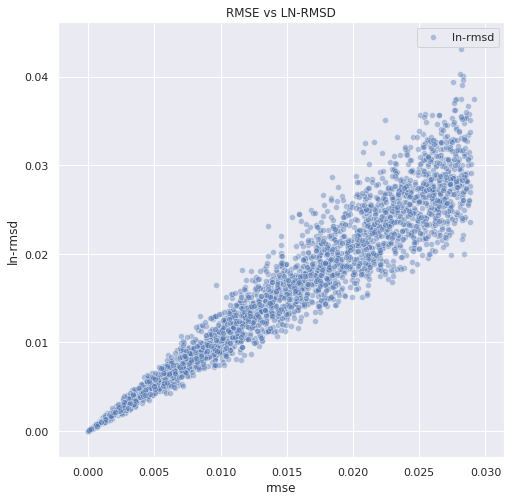

In [35]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
sns.scatterplot(df["rmse"], df["ln-rmsd"], alpha=0.4, ax=ax1, label="ln-rmsd")
plt.title("RMSE vs LN-RMSD")


Text(0.5,1,'RMSE vs RMSD')

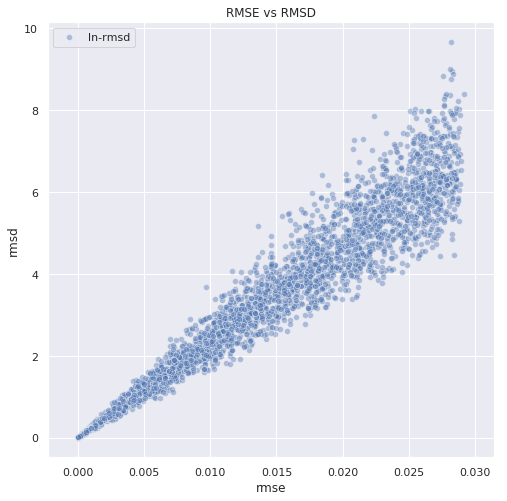

In [36]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
sns.scatterplot(df["rmse"], df["rmsd"], alpha=0.4, ax=ax1, label="ln-rmsd")
plt.title("RMSE vs RMSD")


(0, 6)

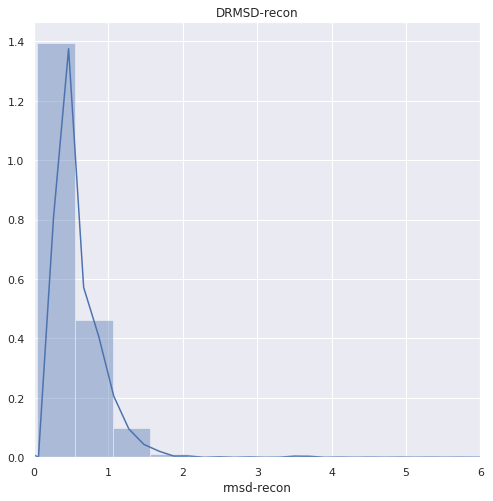

In [68]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
sns.distplot(df_nona["rmsd-recon"])
plt.title("DRMSD-recon")
plt.xlim((0,6))

In [70]:
df_nona[df_nona["rmsd-recon"]>2]

rmse       rmsd  rmsd-recon      drmsd  drmsd-recon    len  \
136   0.500875  28.175291    3.538753  25.870548     3.923899  267.0   
325   0.644805  17.931596    3.532000  12.919639     2.936120  139.0   
794   0.635858   8.193934    2.212150   8.908066     1.415691   28.0   
935   0.726552  20.535724   25.393363  19.703093    17.769329  207.0   
1221  0.270055  28.257773   21.611275  27.558725    12.586975  237.0   
1807  0.334096  21.203844   14.069112  19.074422     9.756935  120.0   
2156  0.153572  35.974953    3.674497  35.786599     2.239134  525.0   

         stdev  ln-drmsd   ln-rmsd  
136   0.640315  0.096893  0.105525  
325   0.893481  0.092947  0.129004  
794   0.932649  0.318145  0.292641  
935   1.105598  0.095184  0.099206  
1221  0.308179  0.116282  0.119231  
1807  0.394587  0.158954  0.176699  
2156  0.170289  0.068165  0.068524

(-0.5, 13)

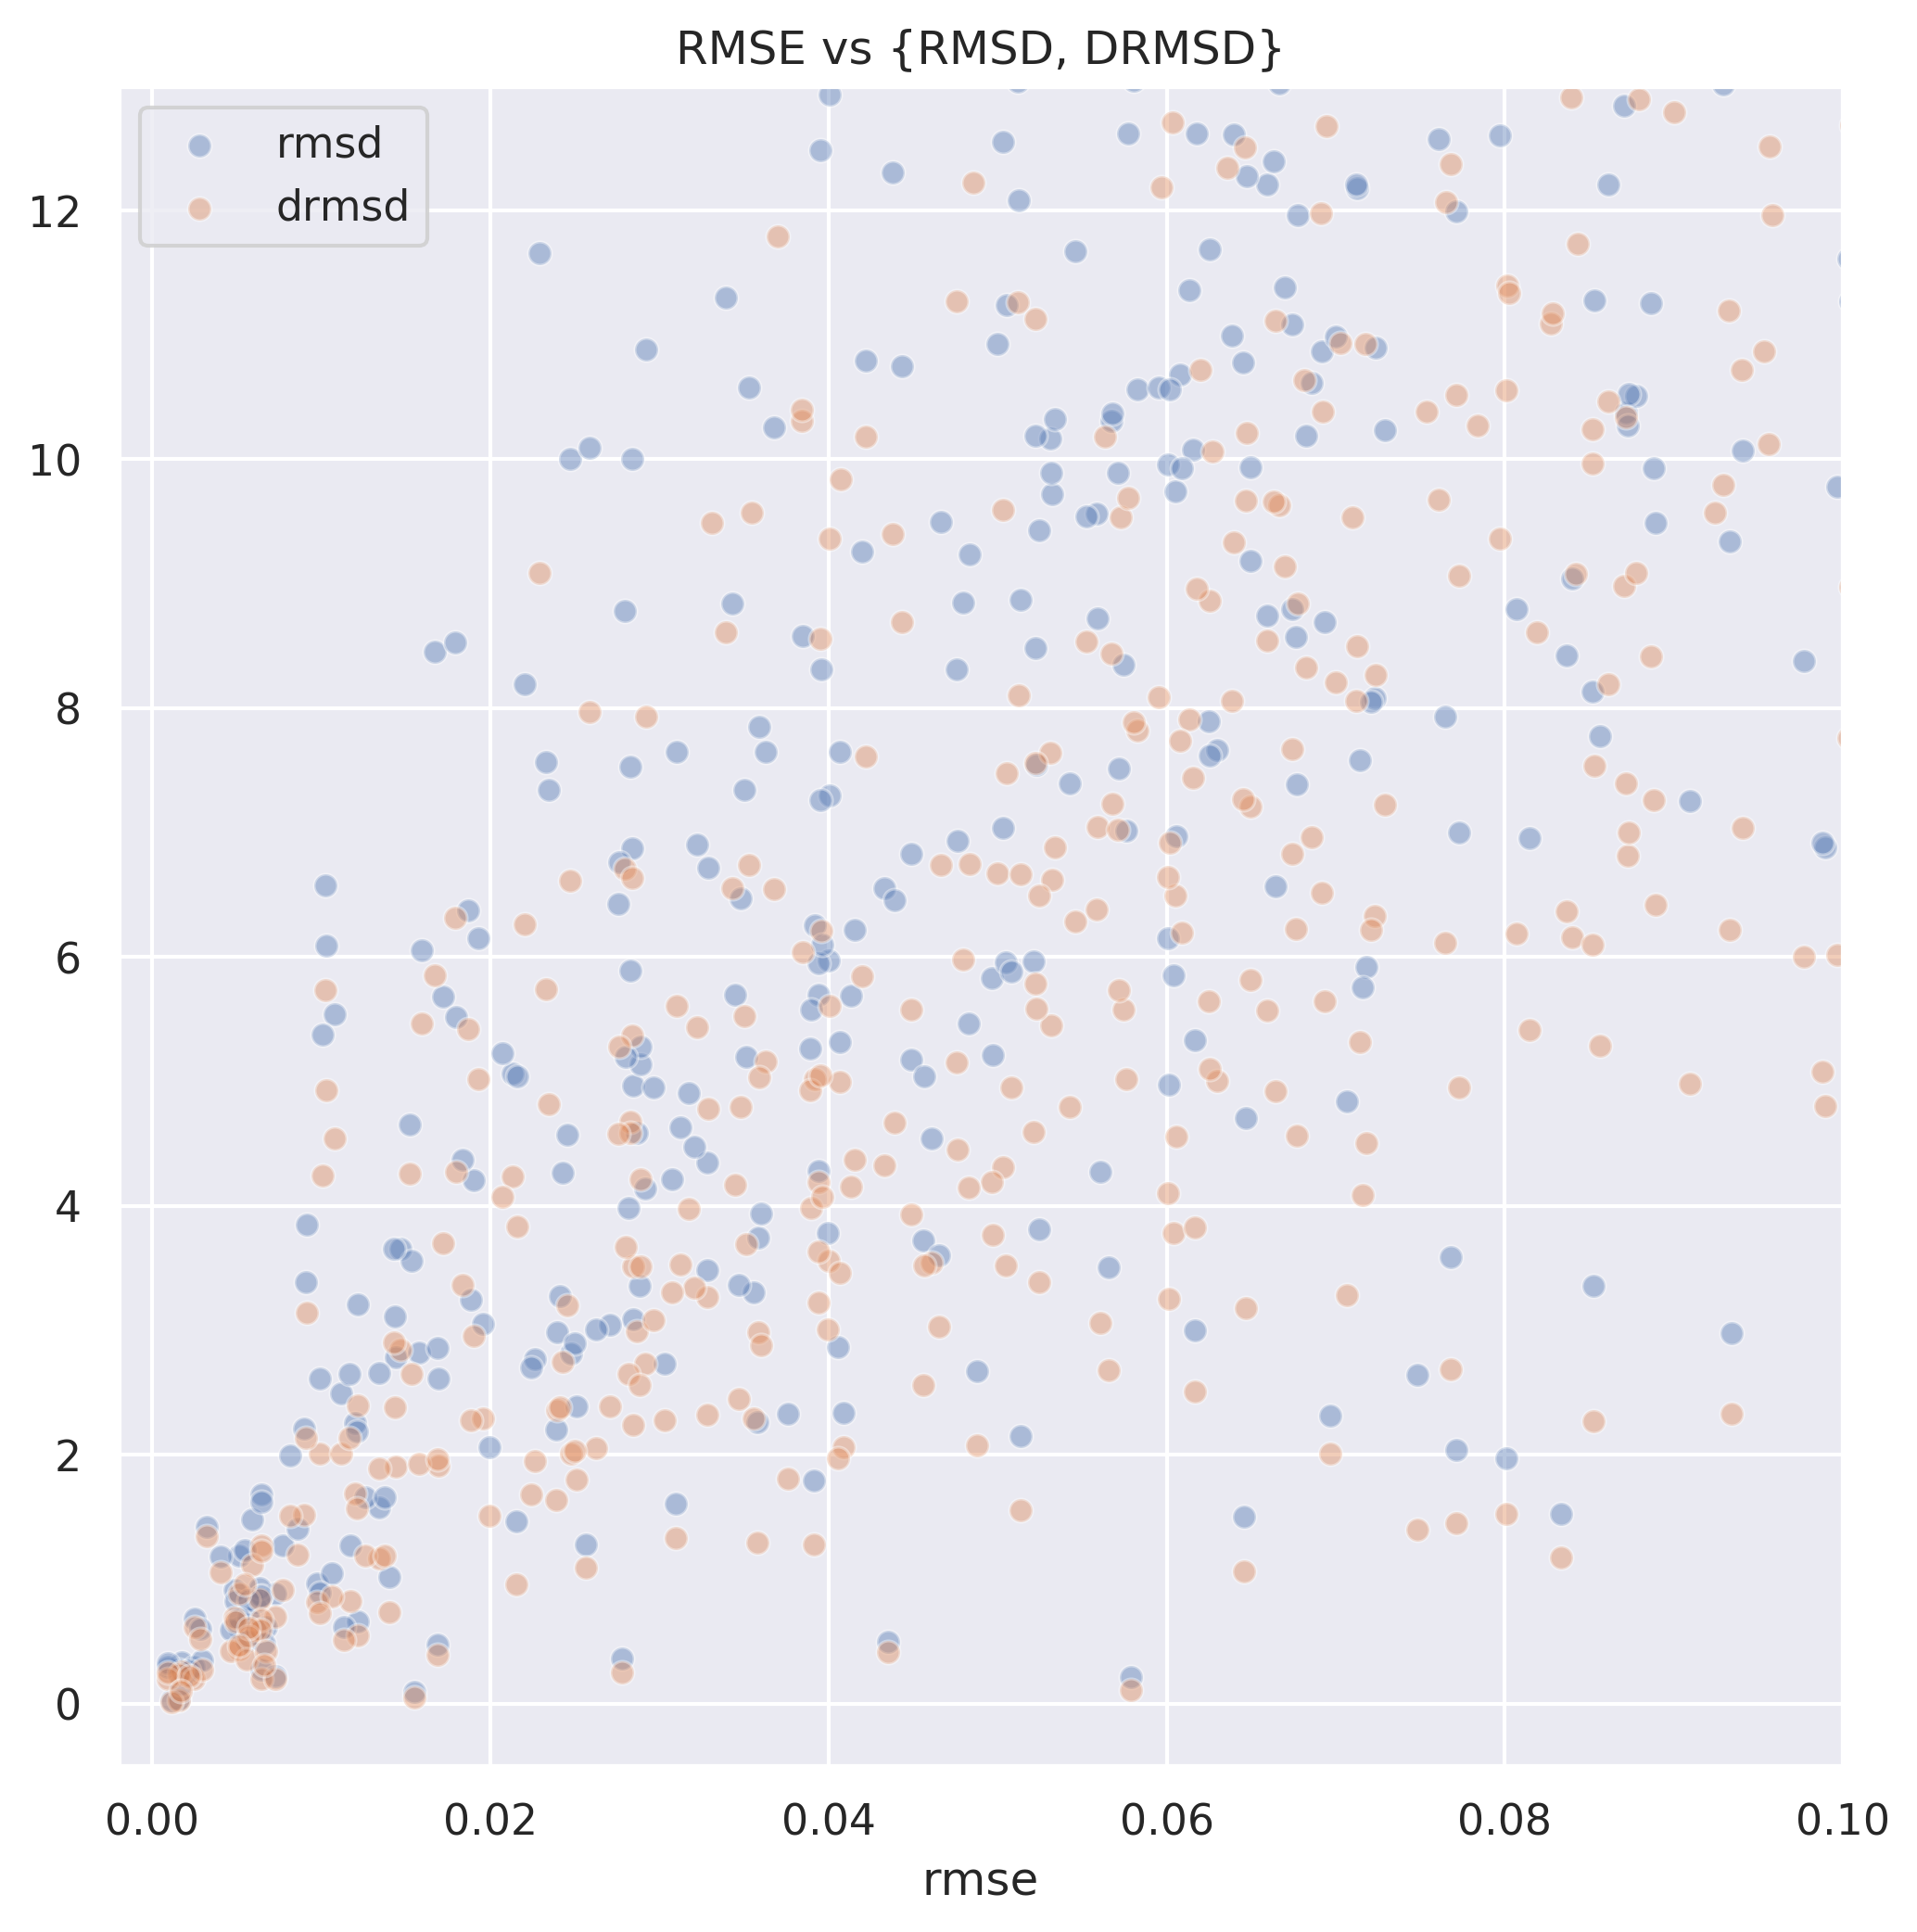

In [84]:
fig = plt.figure(figsize=(8,8), dpi=300)
ax1 = fig.add_subplot(111)
sns.scatterplot(df["rmse"], df["rmsd"], alpha=0.4, ax=ax1, label="rmsd")
sns.scatterplot(df["rmse"], df["drmsd"], alpha=0.4, ax=ax1, label="drmsd")
plt.ylabel("")
plt.legend()
plt.title("RMSE vs {RMSD, DRMSD}")
plt.xlim((-.002,0.1))
plt.ylim((-.5,13))

(-0.002, 0.1)

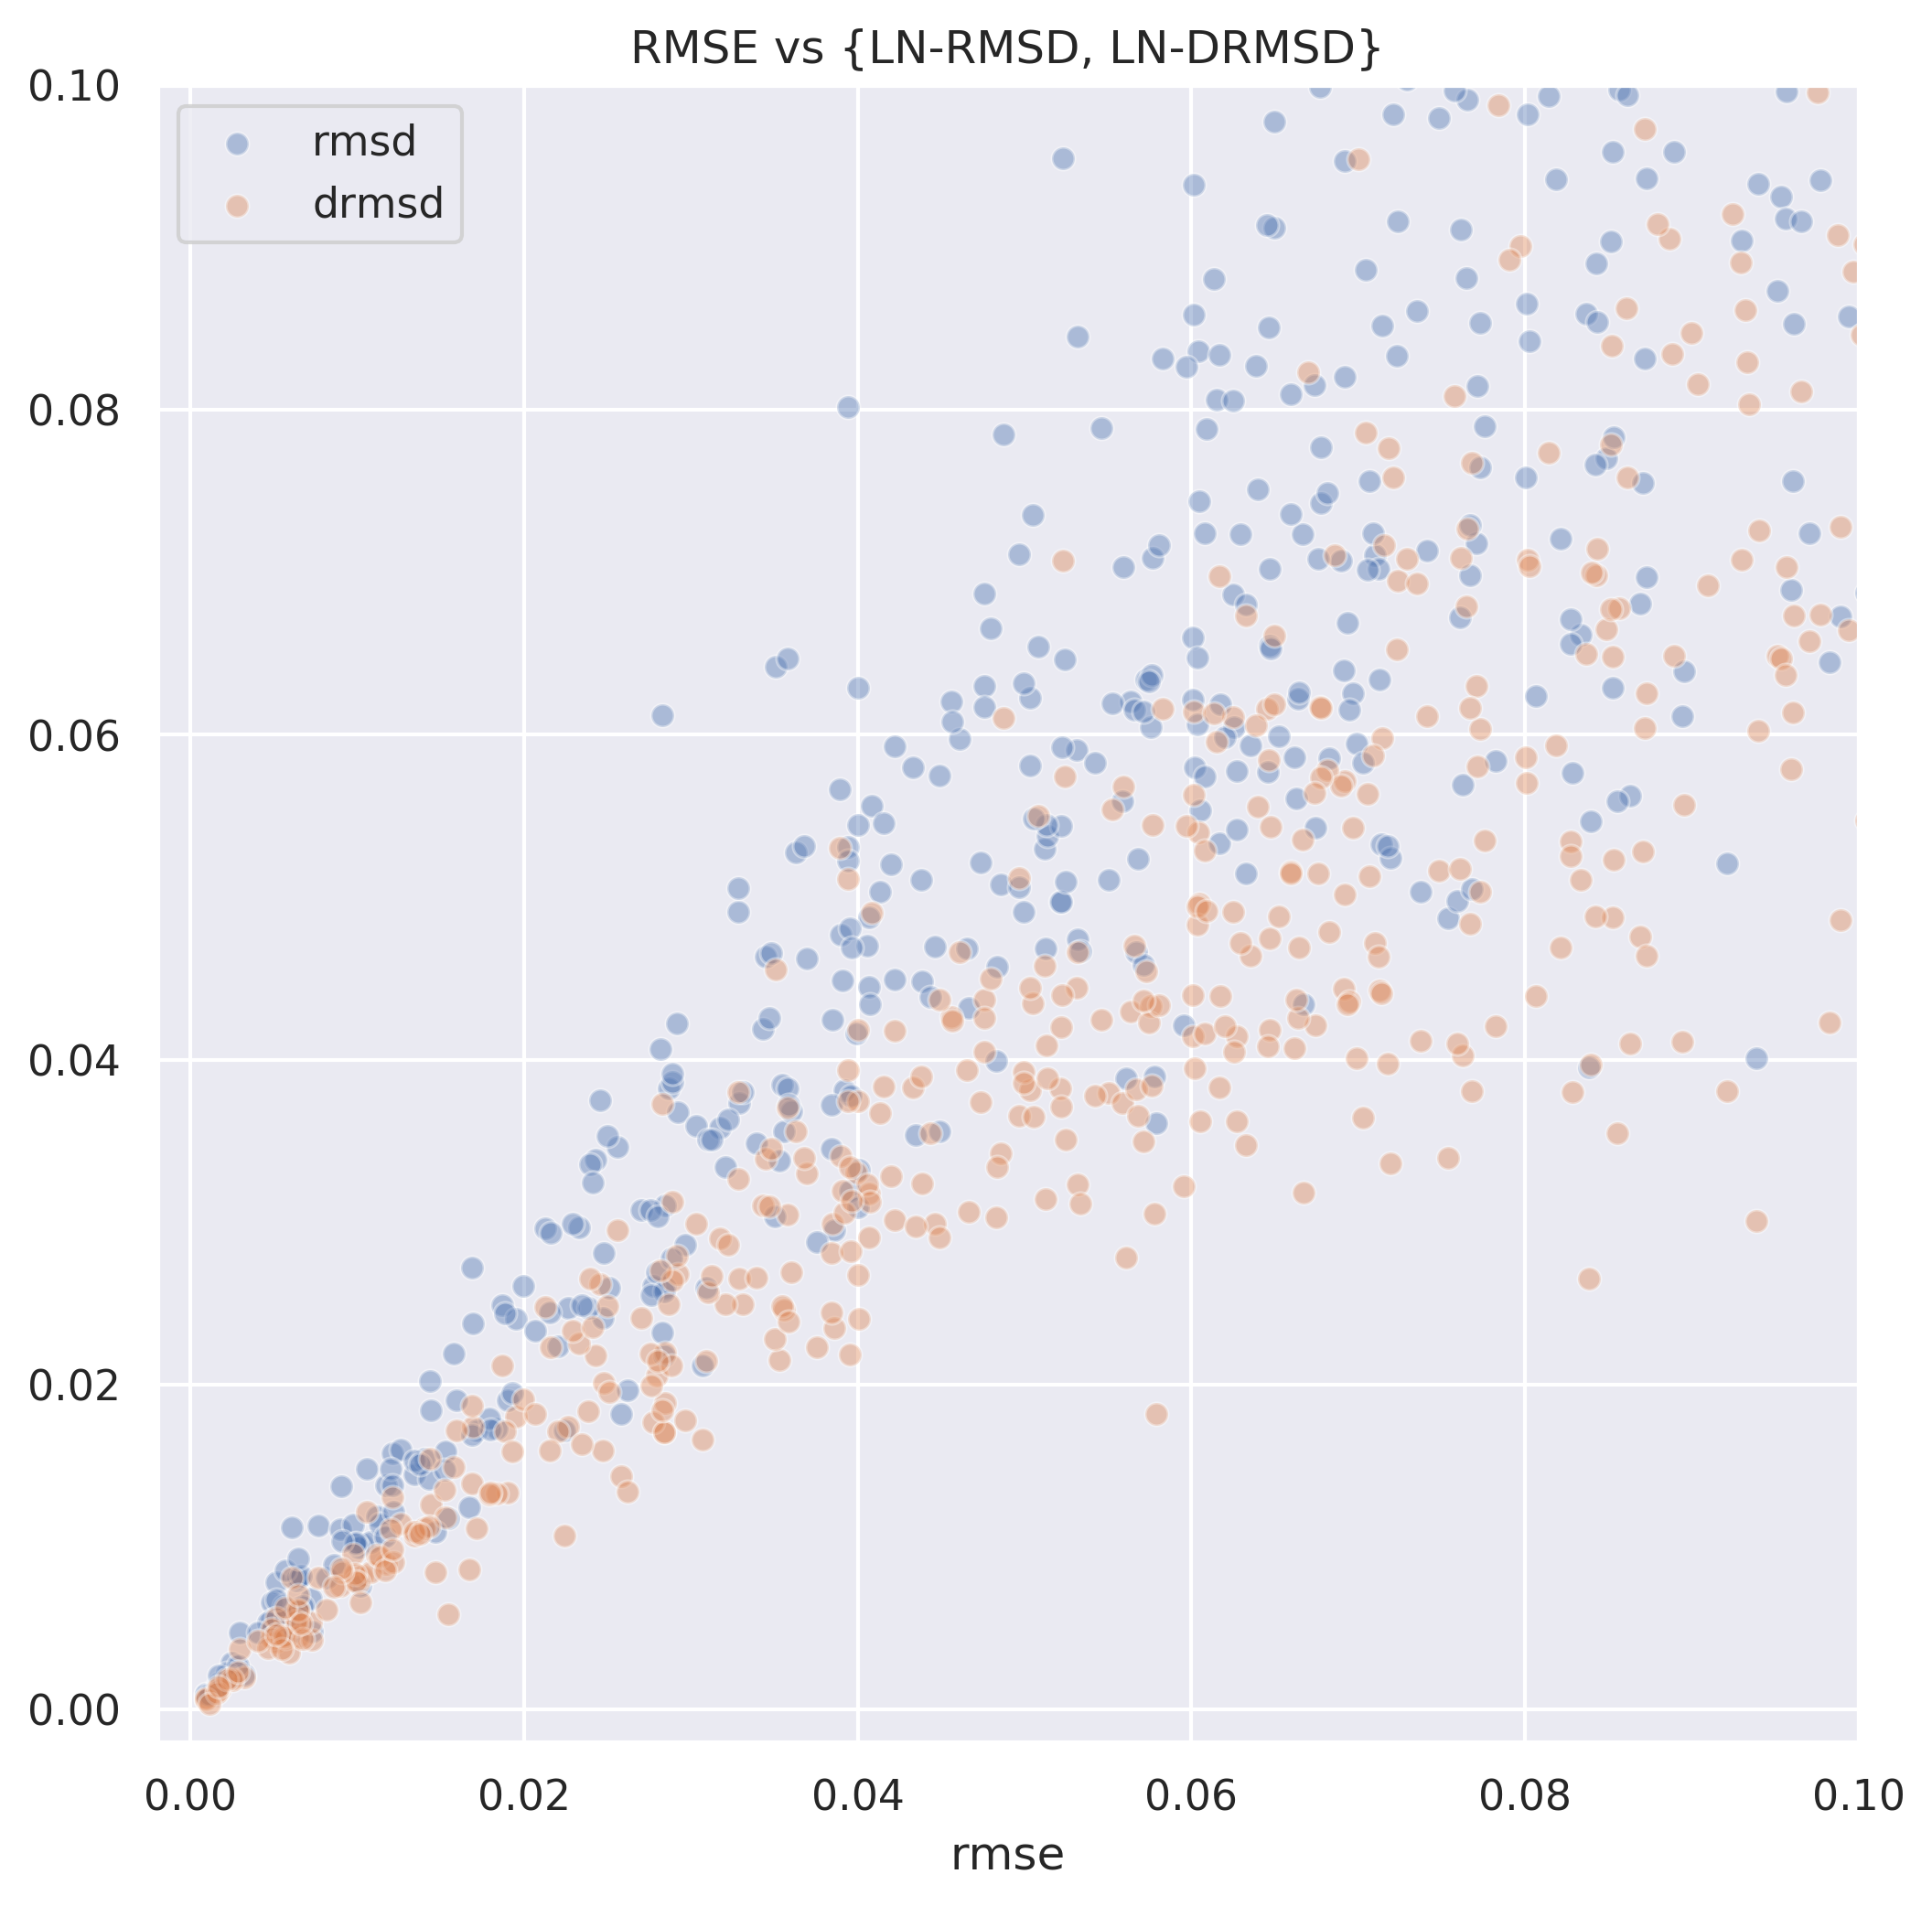

In [90]:
fig = plt.figure(figsize=(8,8), dpi=300)
ax1 = fig.add_subplot(111)
sns.scatterplot(df["rmse"], df["ln-rmsd"], alpha=0.4, ax=ax1, label="rmsd")
sns.scatterplot(df["rmse"], df["ln-drmsd"], alpha=0.4, ax=ax1, label="drmsd")
plt.ylabel("")
plt.legend()
plt.title("RMSE vs {LN-RMSD, LN-DRMSD}")
plt.xlim((-.002,0.1))
plt.ylim((0-.002,.10))

(-2, 70)

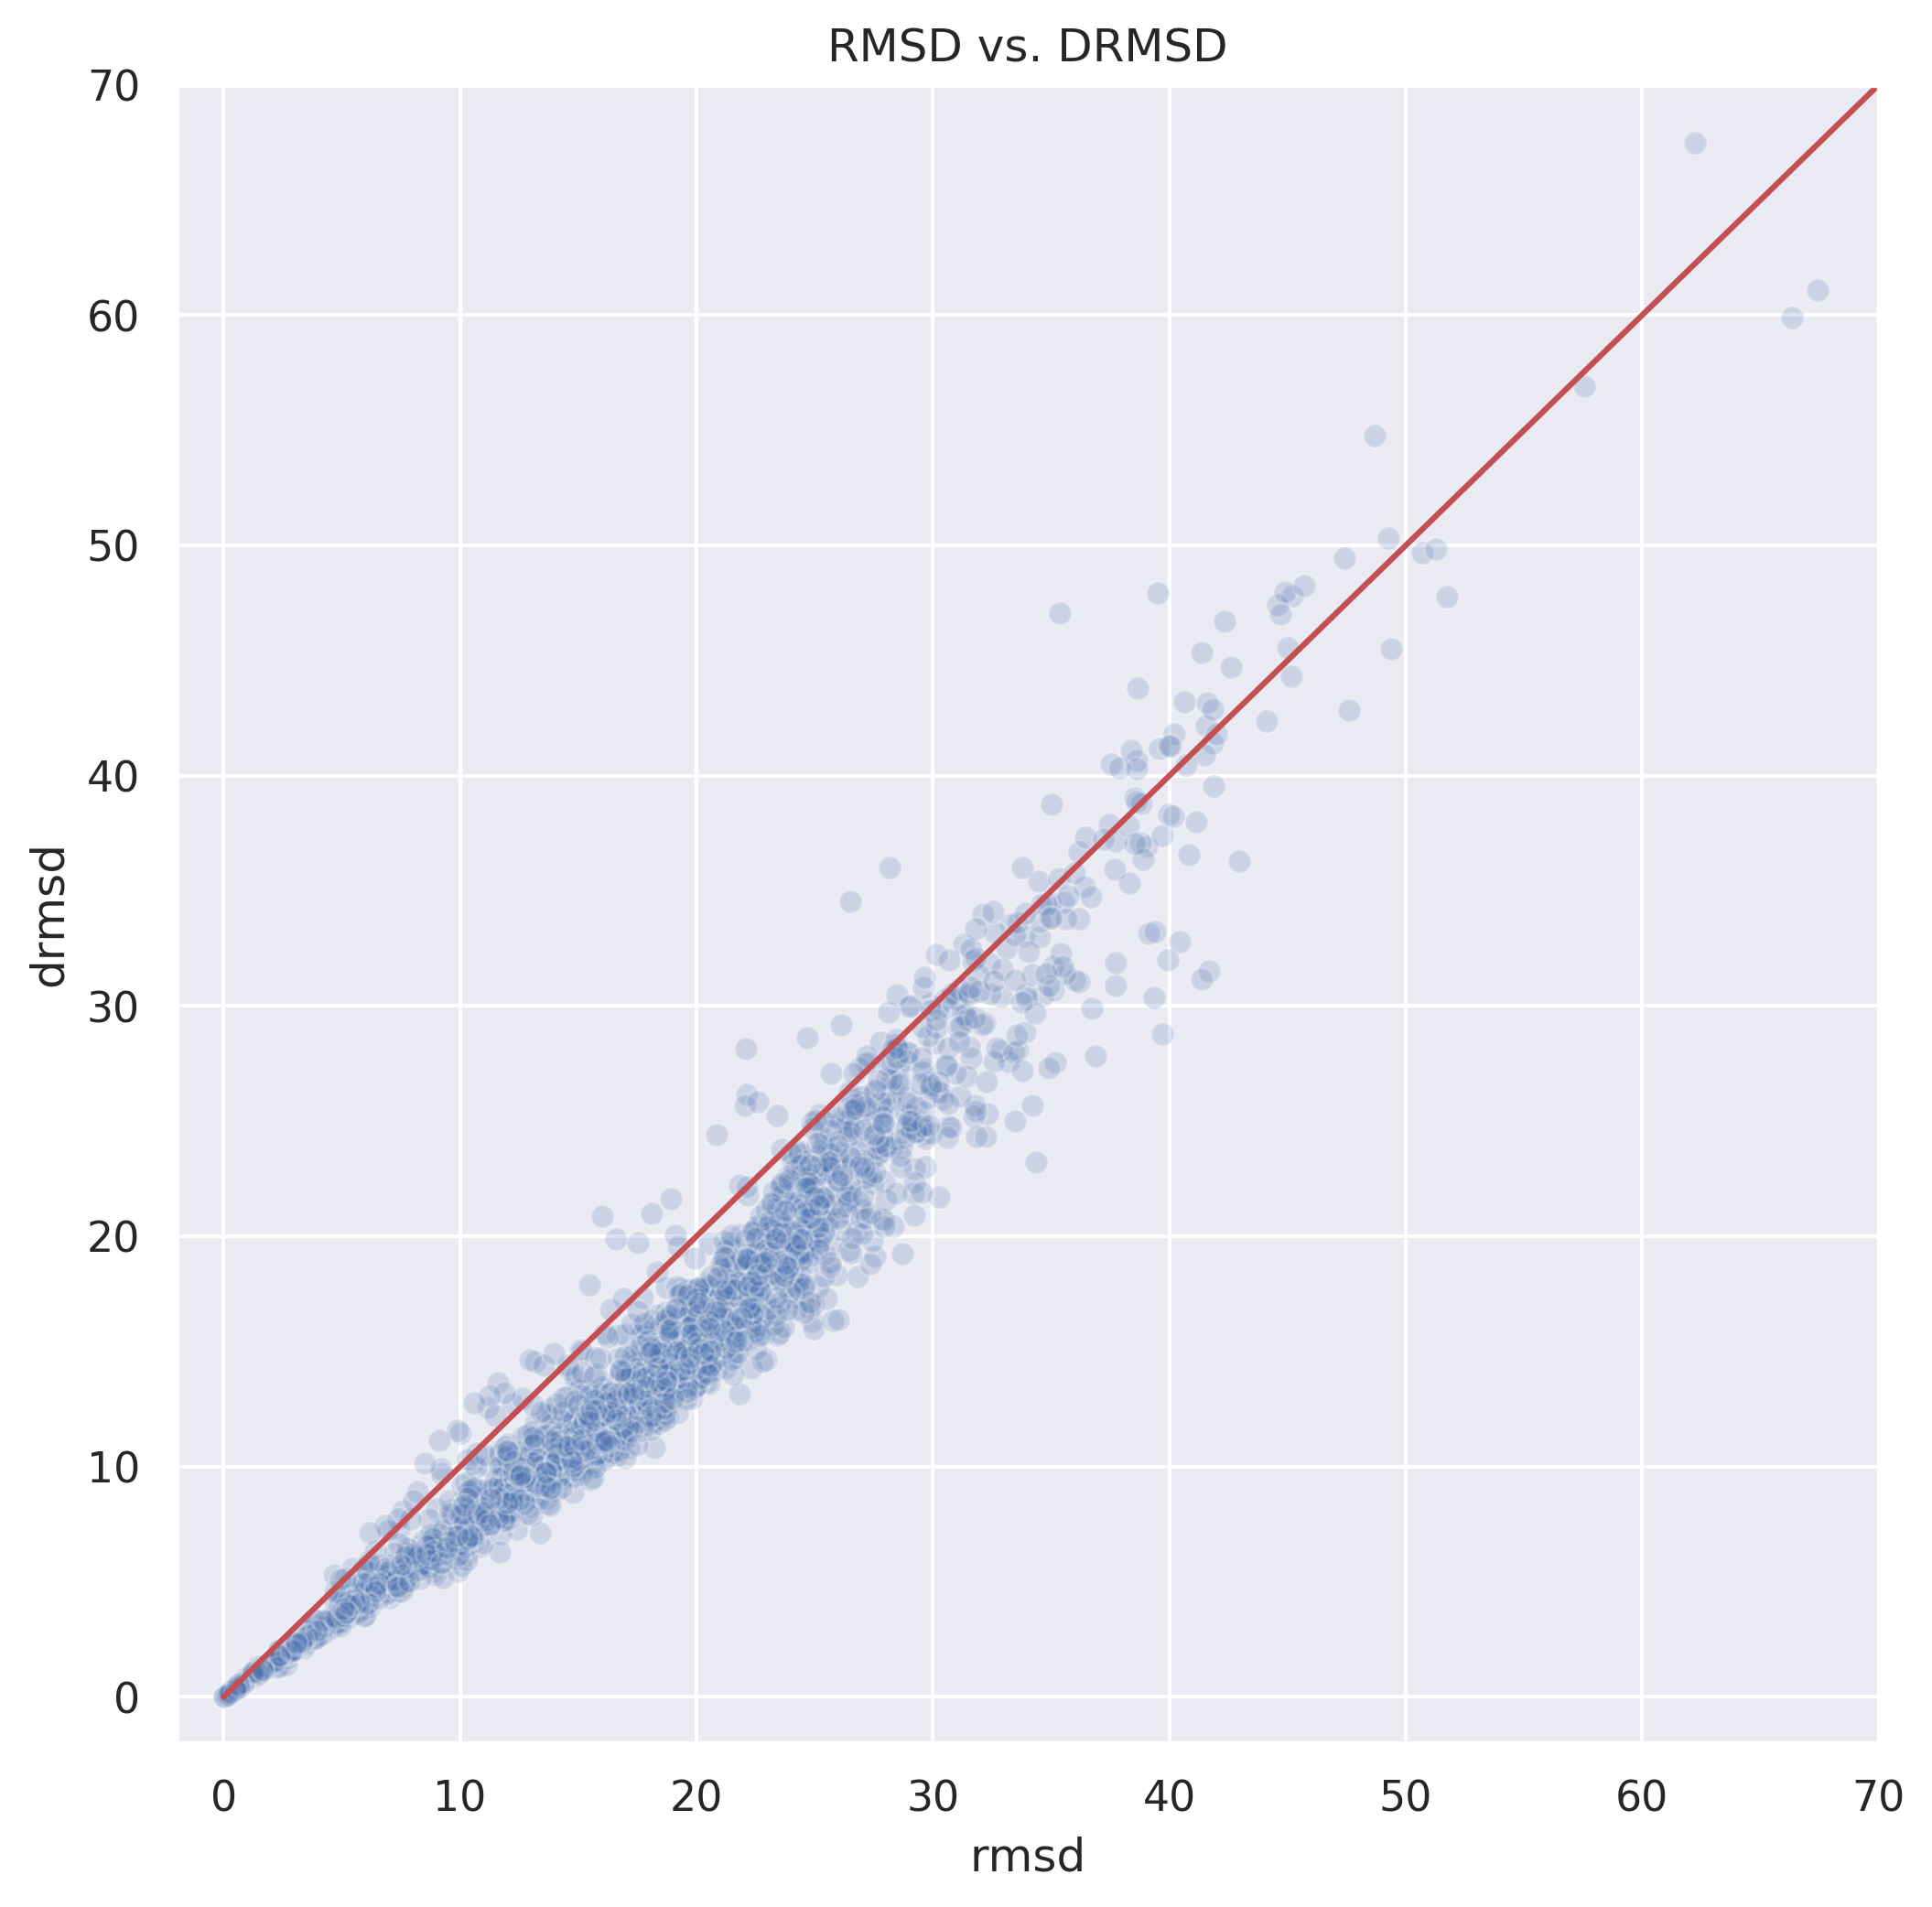

In [92]:
fig = plt.figure(figsize=(8,8), dpi=300)
ax1 = fig.add_subplot(111)
sns.scatterplot(df["rmsd"], df["drmsd"], alpha=0.2)
X_plot = np.linspace(0, 150, 100)
Y_plot = np.linspace(0, 150, 100)
plt.plot(X_plot, Y_plot, color='r')
plt.title("RMSD vs. DRMSD")
plt.xlim((-2, 70))
plt.ylim((-2, 70))

Text(0.5,1,'STDEV vs. RMSE')

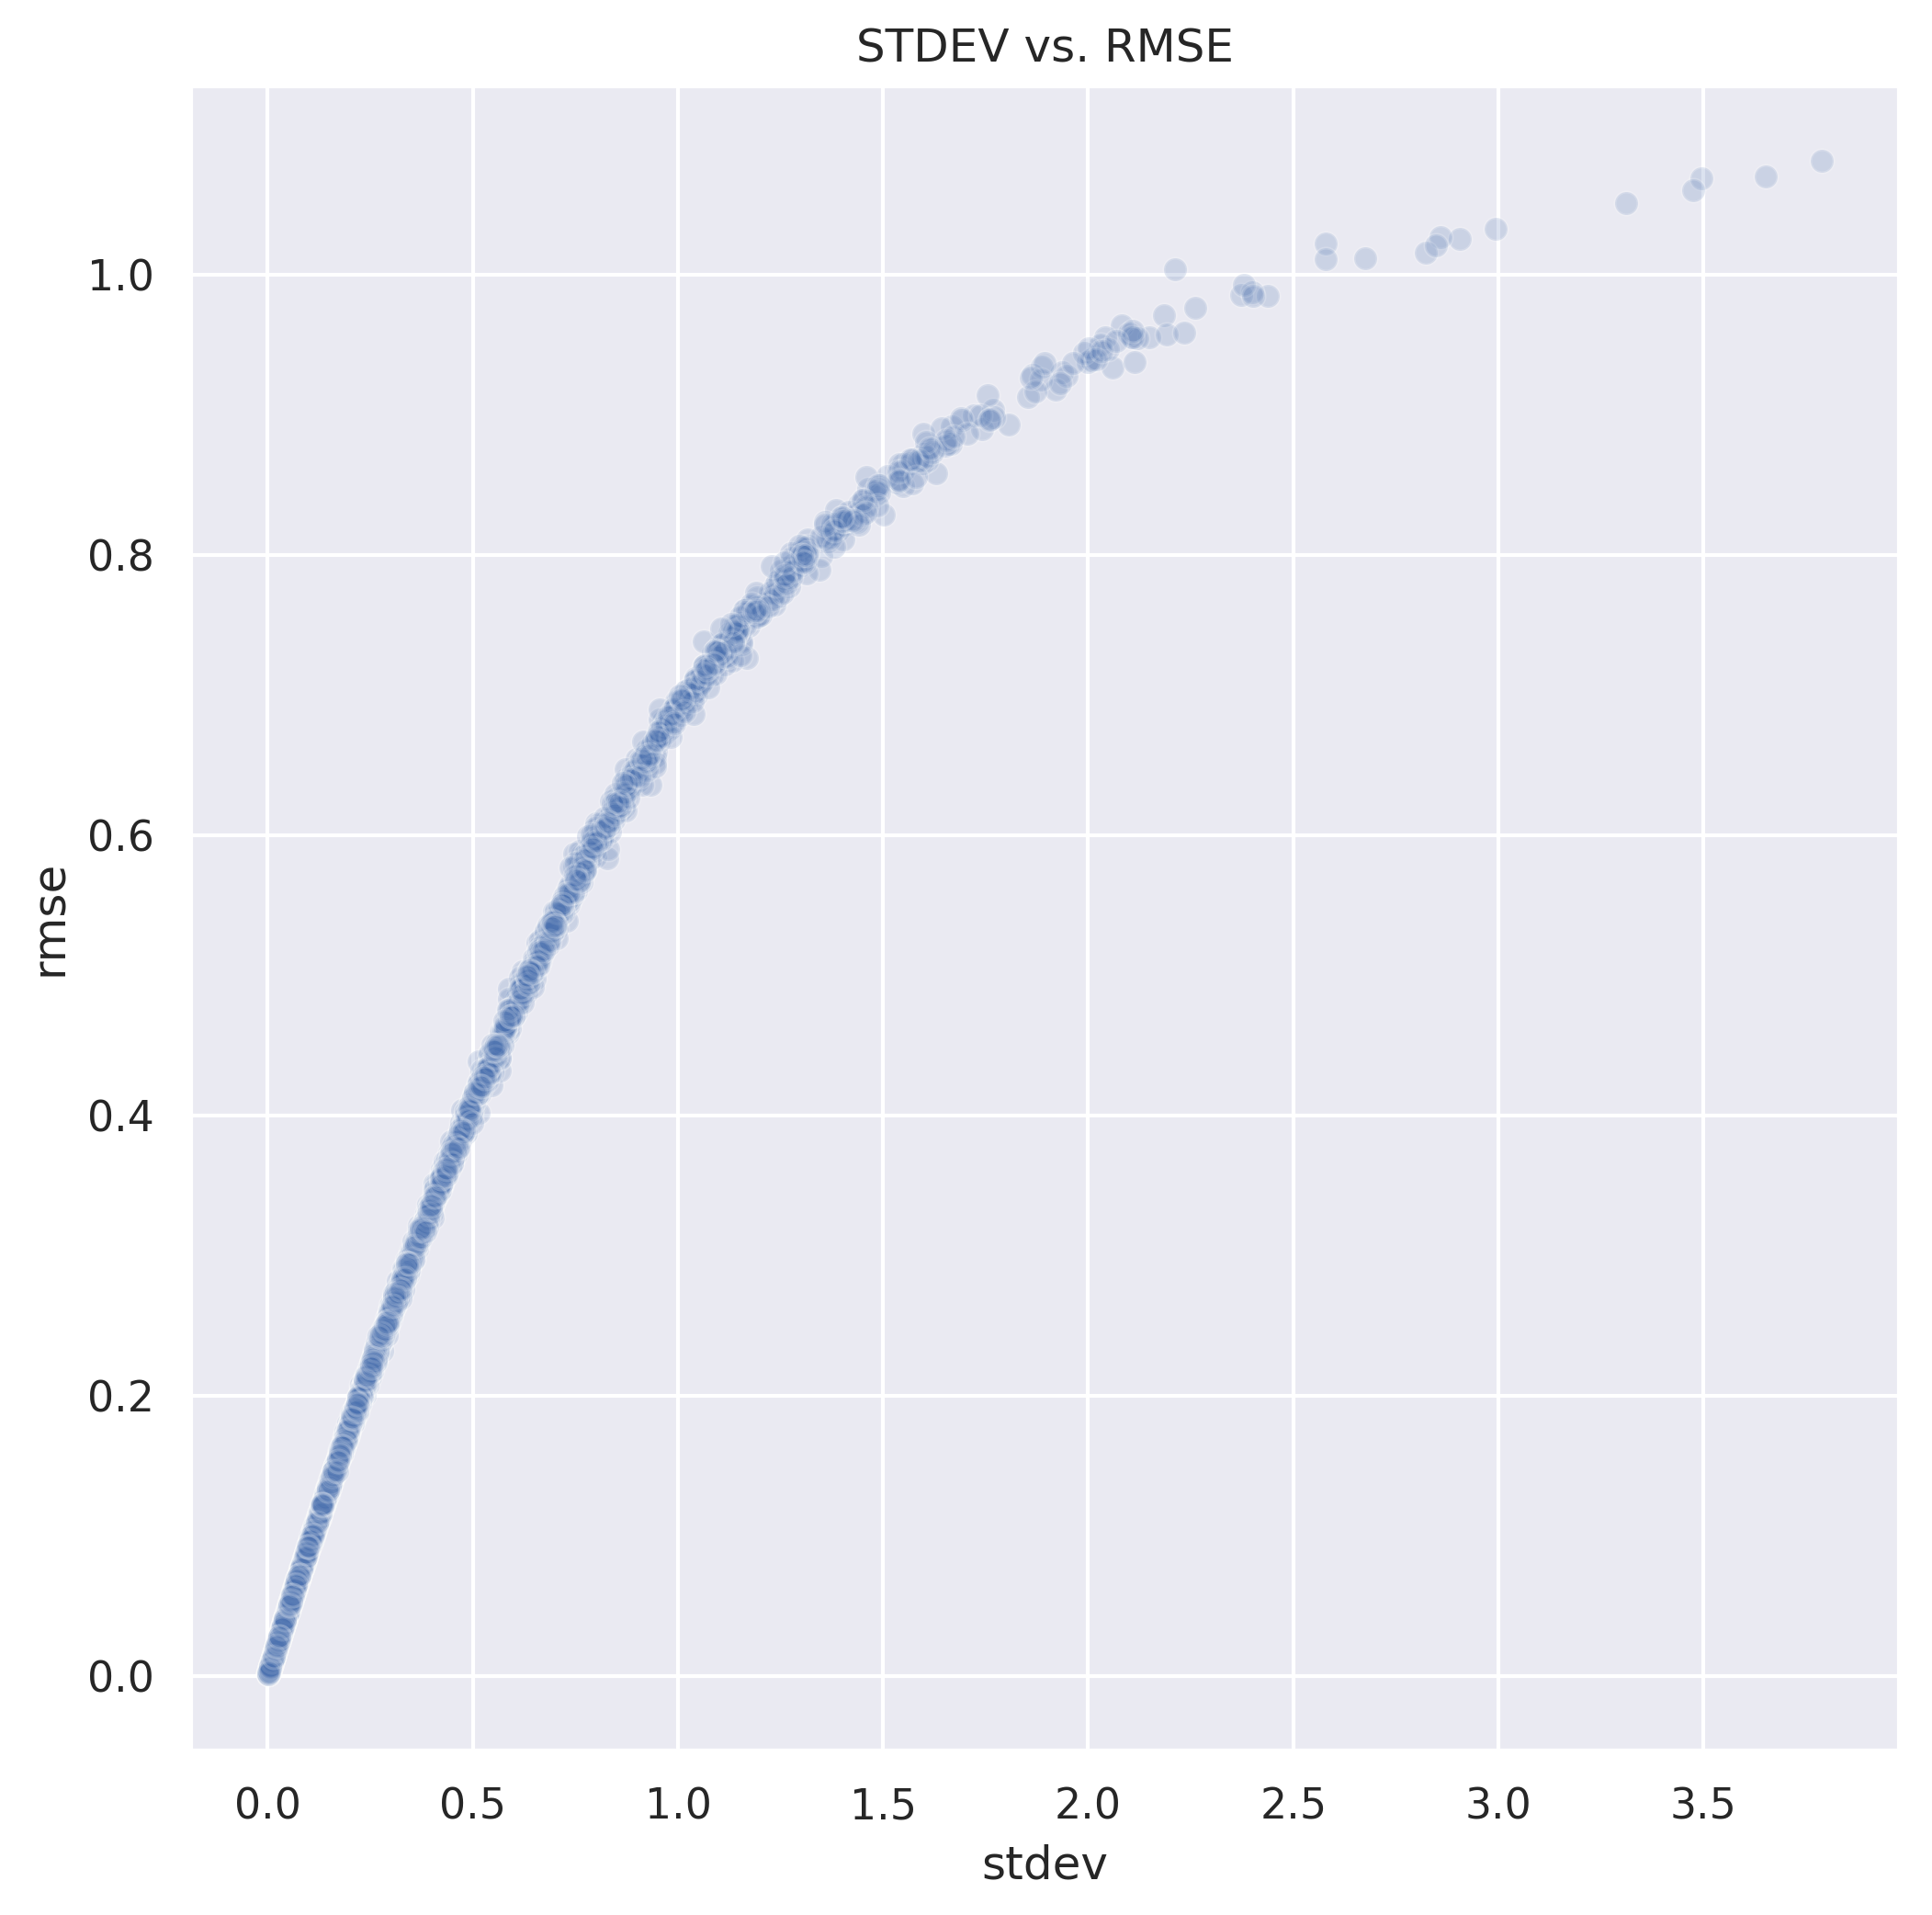

In [97]:
fig = plt.figure(figsize=(8,8), dpi=300)
ax1 = fig.add_subplot(111)
sns.scatterplot(df["stdev"], df["rmse"], alpha=0.2)
X_plot = np.linspace(0, 150, 100)
Y_plot = np.linspace(0, 150, 100)
# plt.plot(X_plot, Y_plot, color='r')
plt.title("STDEV vs. RMSE")
# plt.xlim((-2, 70))
# plt.ylim((-2, 70))

(-0.001, 0.03)

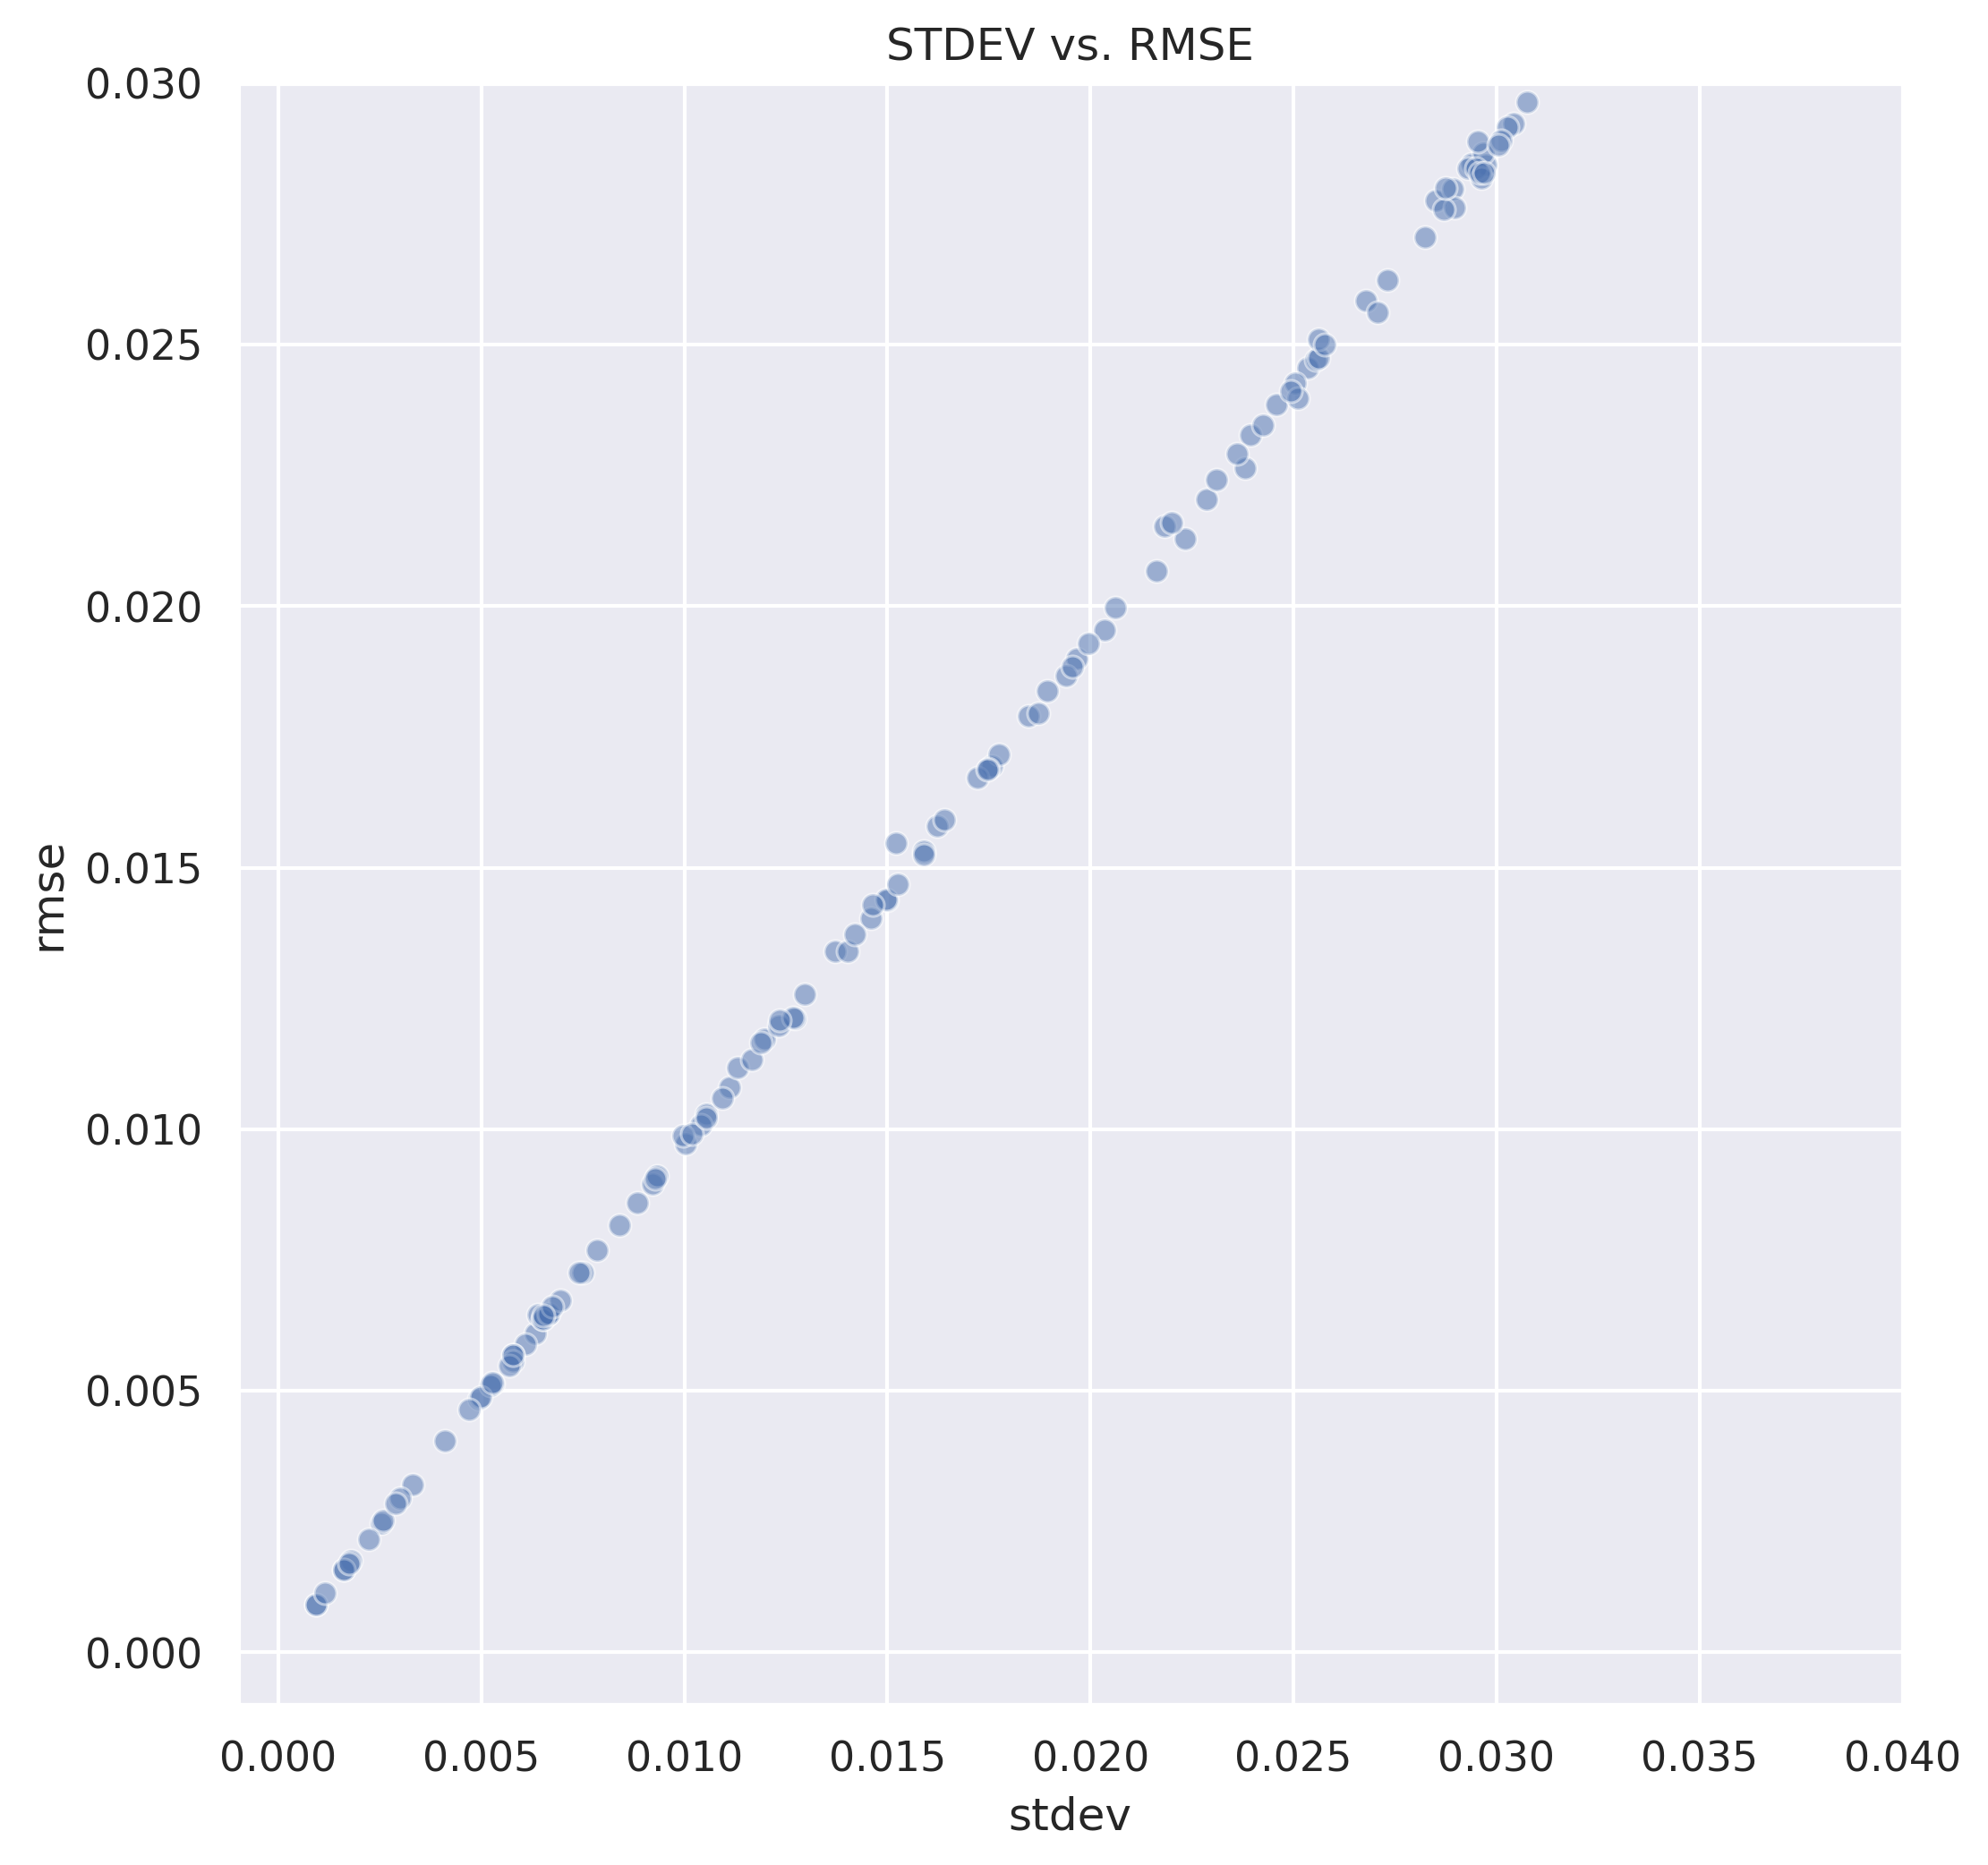

In [115]:
fig = plt.figure(figsize=(8,8), dpi=300)
ax1 = fig.add_subplot(111)
sns.scatterplot(df["stdev"], df["rmse"], alpha=0.5)
plt.title("STDEV vs. RMSE")
plt.xlim((-.001, 0.04))
plt.ylim((-.001, .03))

Text(0.5,1,'Distribution of Noise Stdev')

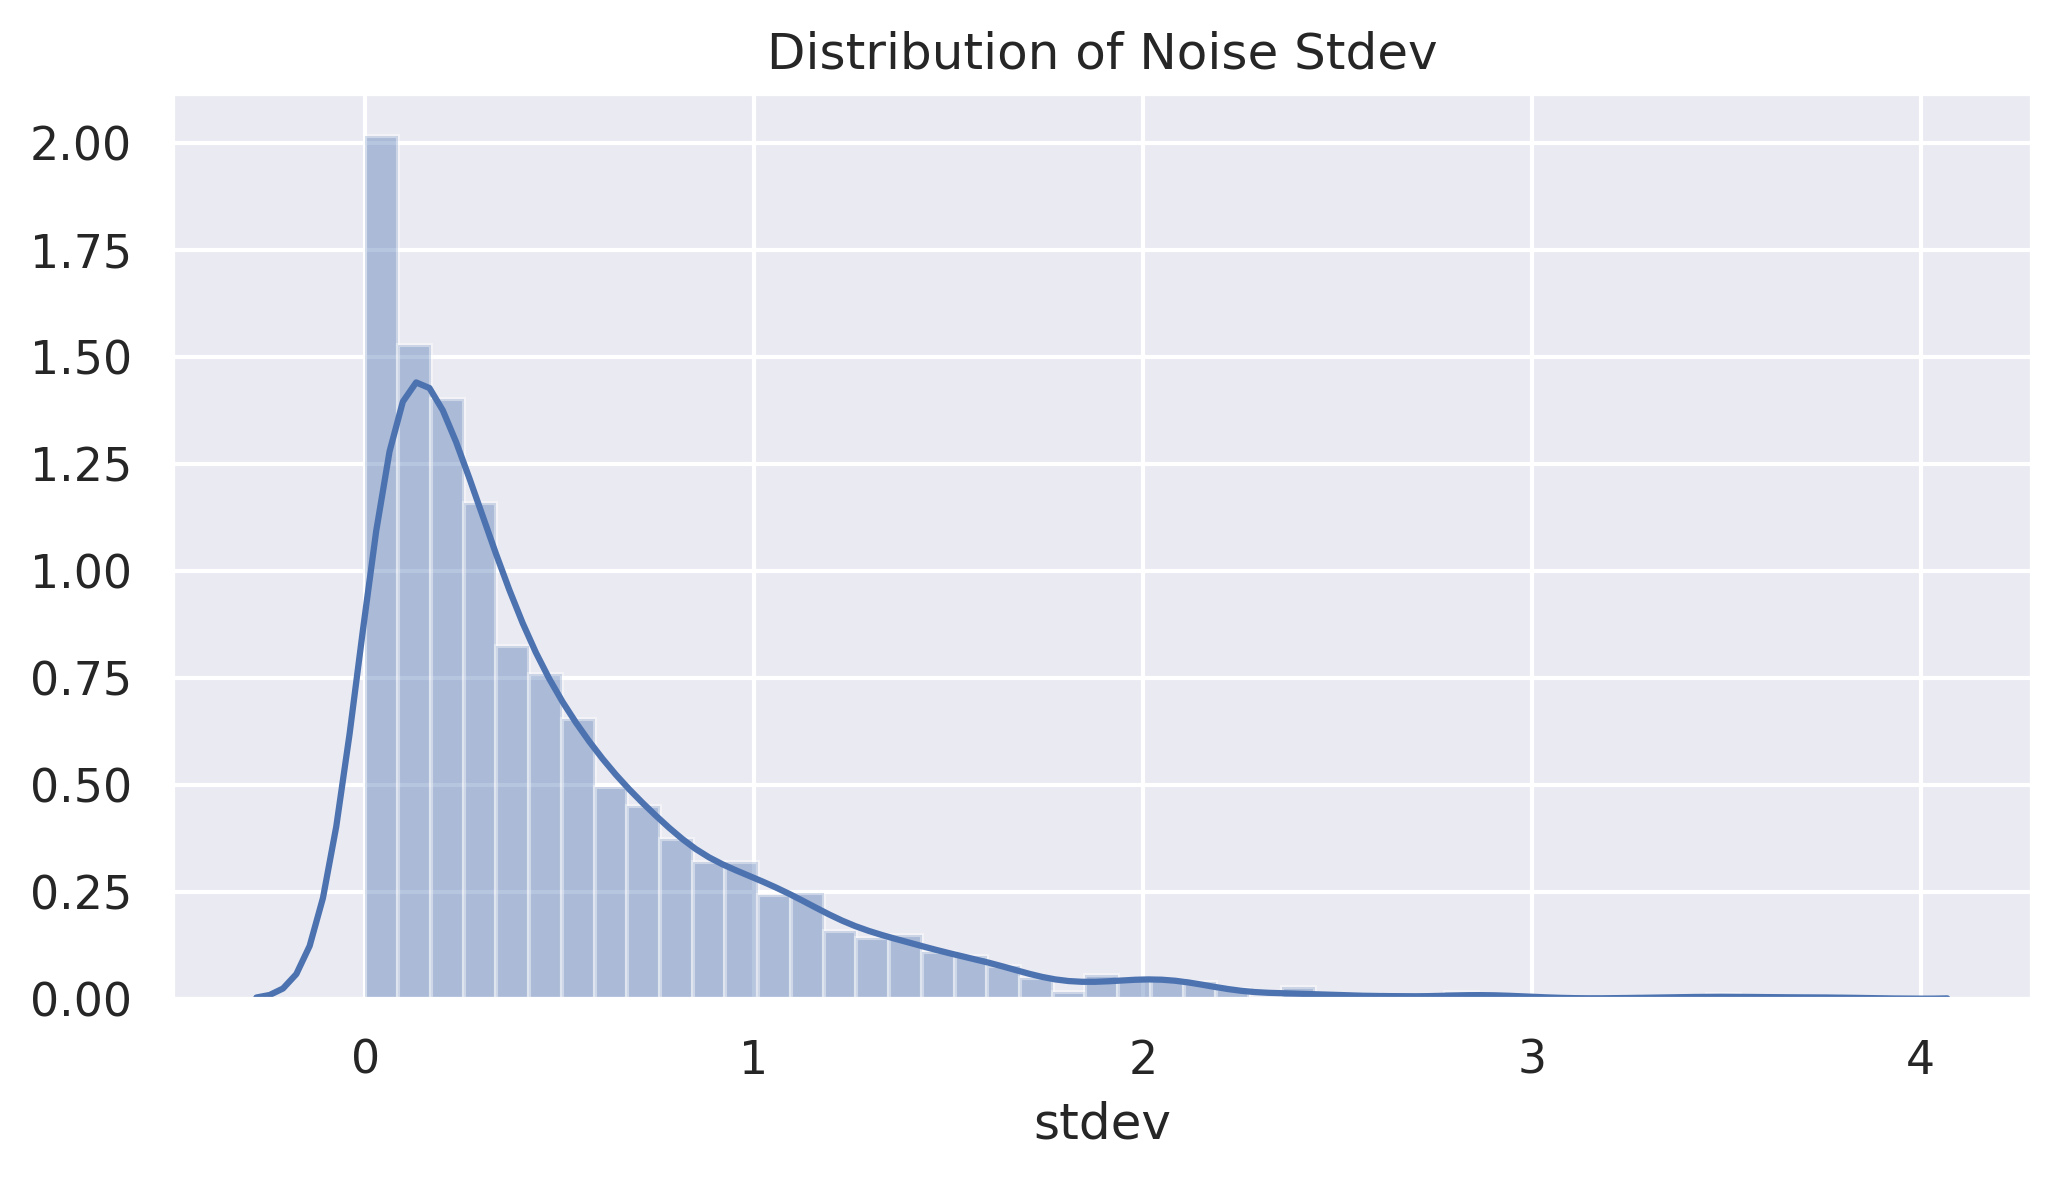

In [73]:
fig = plt.figure(figsize=(8,4), dpi=300)
sns.distplot(df_nona["stdev"])
plt.title("Distribution of Noise Stdev")

In [39]:
df_nona = df.dropna()

Text(0.5,1,'Distribution of RMSD')

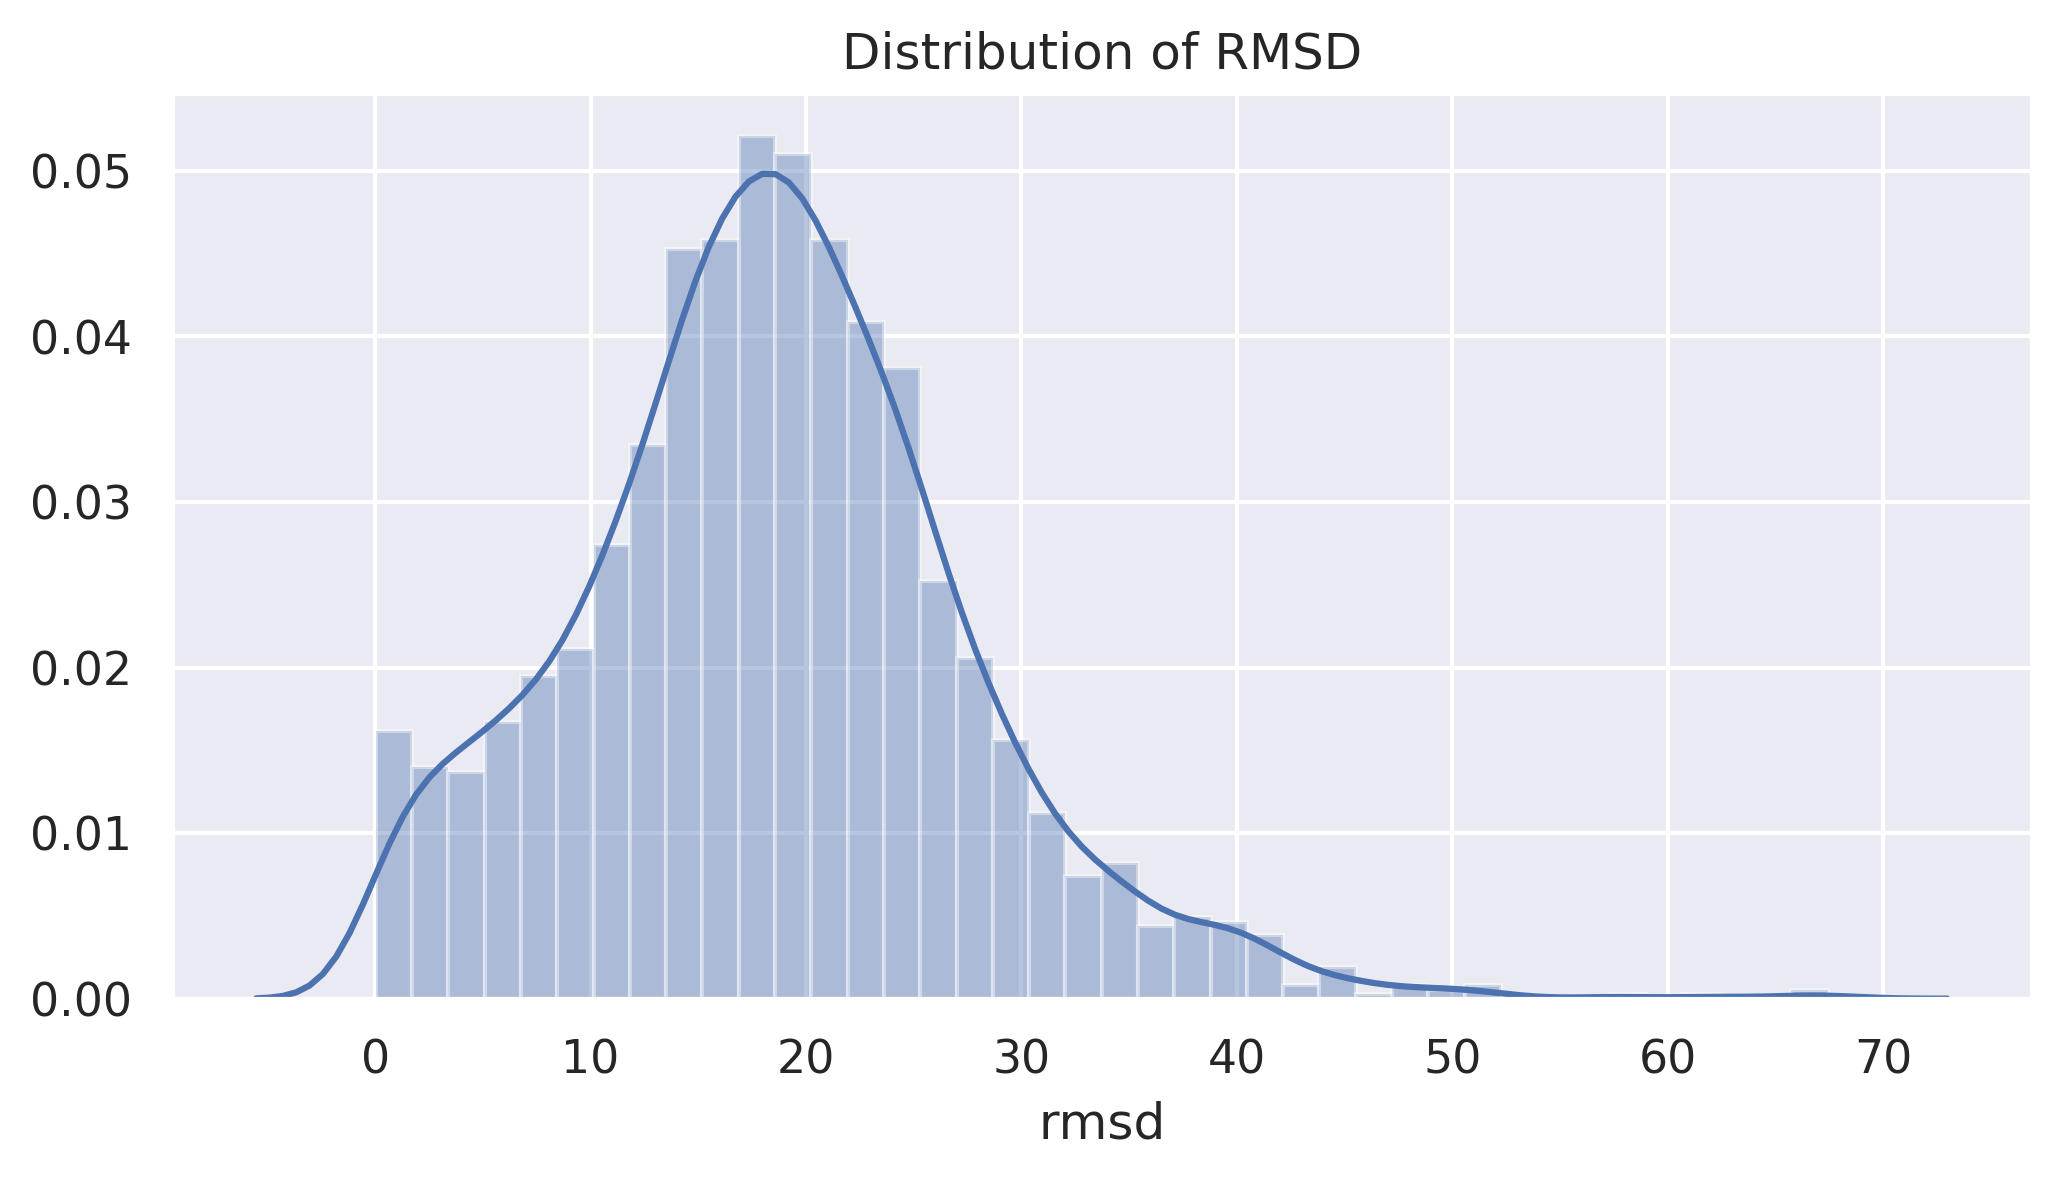

In [93]:
fig = plt.figure(figsize=(8,4), dpi=300)
sns.distplot(df_nona["rmsd"])
plt.title("Distribution of RMSD")

Text(0.5,1,'Fitting Polynomials to RMSE vs LN-RMSD')

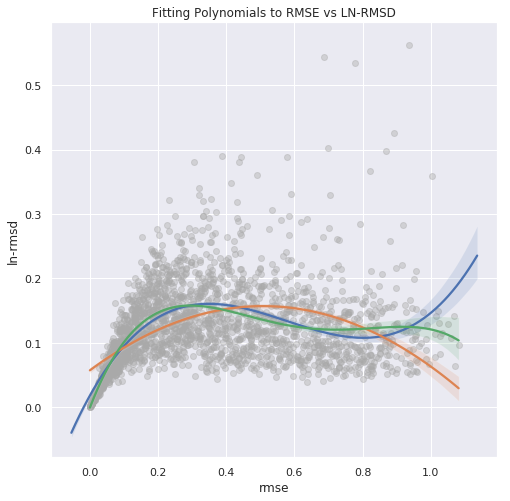

In [46]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ax = sns.regplot(x="rmse", y="ln-rmsd", data=df, 
                 scatter_kws={"alpha": 0.4, "color": "darkgrey"},
                 order=3, truncate=False)
ax = sns.regplot(x="rmse", y="ln-rmsd", data=df, 
                 scatter_kws={"alpha": 0},
                 order=2, truncate=True)
ax = sns.regplot(x="rmse", y="ln-rmsd", data=df, 
                 scatter_kws={"alpha": 0},
                 order=4, truncate=True)
plt.title("Fitting Polynomials to RMSE vs LN-RMSD")

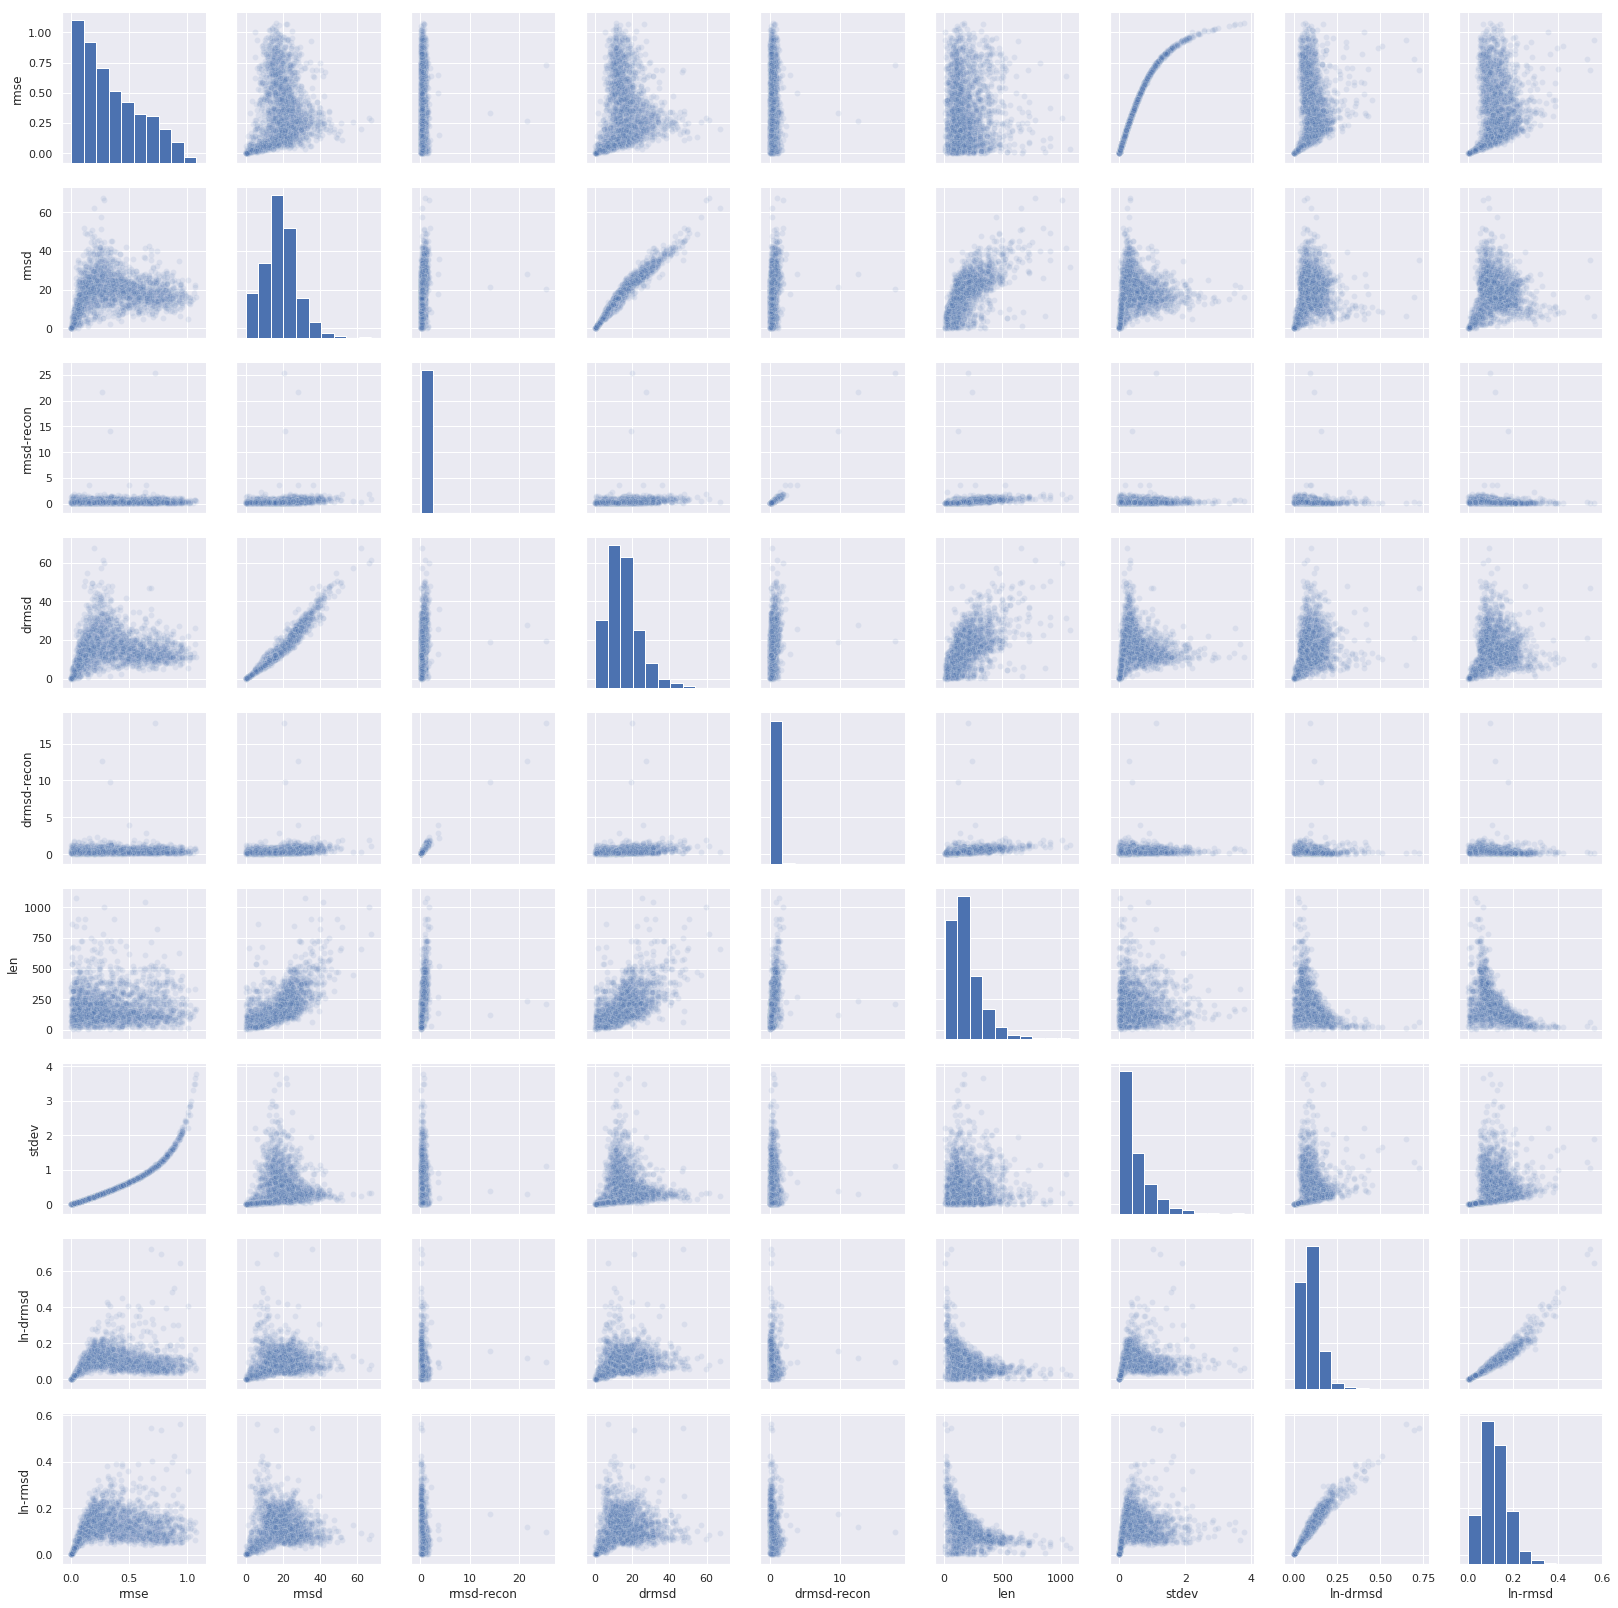

In [56]:
sns.pairplot(df_nona,  kind="scatter", plot_kws={'alpha':0.1})

In [ ]:
results

In [ ]:
df["ln-drmsd"] = df["drmsd"] / df["len"]

In [ ]:
sns.scatterplot(df["rmse"], df["rmsd"])

In [ ]:
sns.scatterplot(df["rmse"], df["drmsd"])

In [ ]:
sns.scatterplot(df["rmse"], df["ln-drmsd"])

In [ ]:
sns.scatterplot(df["len"], df["drmsd-recon"])

In [ ]:
from protein_transformer.protein.PDB_Creator import PDB_Creator
creator1 = PDB_Creator(c.numpy(), seq=seq, atoms_per_res=3)
creator2 = PDB_Creator(get_backbone_from_full_coords(crd), seq=seq, atoms_per_res=3)

In [ ]:
creator1.save_pdb("reconstructed.pdb")

In [ ]:
creator2.save_pdb("original.pdb")

In [ ]:
pwd1 = protein_transformer.losses.pairwise_internal_dist(c)
pwd2 = protein_transformer.losses.pairwise_internal_dist(torch.tensor(crd))

In [ ]:
pwd2

In [ ]:
pwd1

In [ ]:
c.numpy()[:50]

In [ ]:
crd[:50]

In [ ]:
torch.isnan(c).any(), np.isnan(crd).any() 

In [ ]:
ang

In [ ]:
np.random.seed(0)
ang_noisy = add_noise(ang, 1, truncate=True, keep_zeros=True)

In [ ]:
ang_noisy = add_noise

In [ ]:
c = get_coordinates_from_numpy_data(seq, ang)

In [ ]:
c.shape

In [ ]:
ang.shape

In [ ]:
327*13